# Project plan:
1. Import required libraries and data.
2. Duplicates removing.
3. Divide the data into training, validation and testing.
4. EDA (Exploratory Data Analysis).

            4.1 Explore missing data.
            4.2 'All_lessons_info' column.
                4.2.1 'Price' column.
                4.2.2 'Main_category' column.
                4.2.3 'Other_categories' column.
                4.2.4 'Taught' column.
                4.2.5 'Level' column.
            4.3 'Teacher_type' column.
            4.4 'Is_native' column.
            4.5 'Languages' column.
            4.6 'Since_date' column.
            4.7 'Country_from' and 'country_living' columns.
            4.8 'Rating' column.
            4.9 'Students_num', 'lessons_num', 'attendance', 'response', 'reviews_num' columns.
            4.10 Text columns preparation.
            4.11 Columns correlation.
5. Validation data preparation.
6. Separate the most expensive lessons.
7. Text data predictions.
8. Model selection.
9. Test data predictions.
10. Conclusions.


# 1. Import required libraries and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time

import pandas as pd
import numpy as np
import re
from collections import Counter
import random
import math

#preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

#models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR, LinearSVR

#for text data
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

#for visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import missingno

In [2]:
# Function for pallete/cmap creation
def sns_palette(s = 230, f=15, n=15, as_cmap=False):
    return sns.diverging_palette(h_neg=s, h_pos=f, n=n, as_cmap=as_cmap) 

In [3]:
sns_palette()

[(0.2509335357076959, 0.4944143311197457, 0.6104170295454563),
 (0.348247620230289, 0.5582185172657456, 0.6585254017292445),
 (0.44556170475288204, 0.6220227034117454, 0.7066337739130327),
 (0.5428757892754752, 0.6858268895577452, 0.754742146096821),
 (0.6482888215876547, 0.7549411680186302, 0.806854329203457),
 (0.7456029061102478, 0.8187453541646301, 0.8549627013872453),
 (0.8429169906328409, 0.8825495403106298, 0.9030710735710336),
 (0.9500410885273657, 0.9458509996282585, 0.9456251837953888),
 (0.9319813785345213, 0.850678731268705, 0.8428103162675693),
 (0.9133678993124408, 0.7570423592755741, 0.74154514111008),
 (0.8947544200903602, 0.6634059872824426, 0.6402799659525903),
 (0.8745918372915289, 0.5619767444864978, 0.5305870141733784),
 (0.8559783580694483, 0.4683403724933665, 0.42932183901588894),
 (0.8373648788473678, 0.3747040005002354, 0.3280566638583996),
 (0.8187513996252873, 0.2810676285071042, 0.22679148870091004)]

In [4]:
#Constants
RANDOM_STATE = 27
RANDOM_STATE_2 = 0
RANDOM_STATE_3 = 121

SNS_PALETTE = sns_palette()
TEXT_COLOR = SNS_PALETTE[0]
COLOR_1, COLOR_2 = SNS_PALETTE[4], SNS_PALETTE[10]

CMAP = sns_palette(as_cmap = True)

In [5]:
#All functions for plotting graphics that will be useful in the project

#general_1
def plot_1(figsize = (10,4)):    
    sns.set_theme(style="white")
    fig = plt.figure(figsize = figsize)
    
#general_2
def plot_2(title, xlabel = '', ylabel = '', title_size = 23, y = 1.1, title_pad = 10): 
    
    plt.tick_params(axis='both', which='major', labelsize=12, colors=TEXT_COLOR, grid_alpha=0.5) 
    plt.title(title, fontdict={'fontsize':title_size, 'color':TEXT_COLOR}, y = y)
    
    plt.xlabel(xlabel, fontdict={'fontsize':12, 'color':TEXT_COLOR})
    plt.ylabel(ylabel, fontdict={'fontsize':12, 'color':TEXT_COLOR})
    
    sns.despine(left=True, bottom=True)

def fig_subplot(title=None, colors={'No':COLOR_1, 'Yes': COLOR_2}, figsize = (16,6), legend = True):
    sns.set_theme(style="white")
    fig = plt.figure(figsize = figsize)
    fig.suptitle(t = title, fontsize=23, fontdict={'color':TEXT_COLOR})
    
    if legend == True:
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        fig.legend(handles, labels)
    return fig

def legend_plot(colors):
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    fig.legend(handles, labels)

def pie_plot(x, labels, title, colors = [COLOR_1, COLOR_2]):   
    plot_1(figsize = (8,8))
    plt.pie(x, labels = labels, colors = colors, autopct='%.0f%%', textprops={'fontsize':13, 'color':TEXT_COLOR})
    plot_2(title = title, y=1)

def line_plot(x, y, title, figsize = (10,4), color = TEXT_COLOR, linewidth=4, xticks=False):    
    plot_1(figsize = figsize)
    g = sns.lineplot(x, y, palette=palette, color =color, linewidth=linewidth)
    if xticks==True:
        g.set_xticks(x.unique())
    plot_2(title = title)
    
def hist_plot(data, title, color = TEXT_COLOR, n=20):
    plot_1()
    plt.hist(data, n, color=color)
    plot_2(title = title)
    
def violin_plot(data, x, y, title=None, palette=[COLOR_1, COLOR_2], figsize = (17, 6), title_size = 23, plot = True):
    if plot == True:
        plot_1(figsize)
    sns.violinplot(x = x, y = y, data=data, palette=palette, bw=.2, cut=1, linewidth=1)
    plot_2(title = title, ylabel='Price', title_size=title_size)

def bar_plot(data, x, y, title=None, palette=[COLOR_1, COLOR_2], figsize =(17, 6), 
             title_size=23, ylabel='Price', plot=True): 
    if plot == True:
        plot_1(figsize)
    sns.barplot(x = x ,y = y, data = data, estimator=np.mean, palette=palette)
    plot_2(title = title, ylabel=ylabel, title_size=title_size)

def heatmap_plot(data, title, figsize = (16, 6)):
    plot_1(figsize=figsize)
    corr_matrix = data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
    heatmap = sns.heatmap(corr_matrix, cmap = CMAP, annot=True,
               fmt='.2f', cbar=True, #linewidths=0.5, linecolor='white',
               center = None, mask=mask, #square=True, 
               cbar_kws = {'shrink': 1,'pad':0.01}, vmin=-1, vmax=1,
               annot_kws = {})
    plot_2(title = title, ylabel='Price')

def scatter_plot(x, y, hue, title, xlabel='', palette = SNS_PALETTE, cmap = CMAP, figsize = (16, 6)):
    plot_1(figsize=figsize)
    scatterplot = sns.scatterplot(x=x, y=y, hue=hue, cmap=cmap, palette=palette)
    plot_2(title = title, xlabel = xlabel, ylabel='Price')

def true_pred_plot(target, pred=[], title=None, y_label=None, legend = True, figsize=(18,8), color_1 = COLOR_1, 
                   color_2 = COLOR_2):
    x_ax = range(len(target))
    plot_1(figsize=figsize)
    sns.lineplot(x_ax, target, linewidth=1, color= color_1)
    if pred != []:
        sns.lineplot(x_ax, pred, linewidth=1.1, color= color_2)
    if legend == True:
        colors = {"Target":color_1, "Predicted": color_2}
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels)
    
    plot_2(title, ylabel=y_label)

def kde_line_plot(x, y, cmap, color, title, xlabel, ylabel, max_val):
    kdeplot = sns.kdeplot(x=x, y=y, fill=True, thresh=0, cmap=cmap, shade=True, cut=10, levels=15)
    kdeplot.set(xlim=(0, max_val), ylim=(0, max_val))
    sns.lineplot(x=list(range(60)), y = list(range(60)), color=color)
    plot_2(title=title, xlabel=xlabel, ylabel=ylabel, title_size = 18)
    

def scatter_line_plot(x, y, color, title, xlabel, ylabel, max_val):
    scatterplot = sns.scatterplot(x=x, y=y, color = color)
    scatterplot.set(xlim=(0, max_val), ylim=(0, max_val))
    sns.lineplot(x=list(range(60)), y = list(range(60)), color=color)
    plot_2(title=title, xlabel=xlabel, ylabel=ylabel, title_size = 18)  
    
def fig_bar_plot(data, list_bin, title, j=5, y='price', figsize=(16,8)):

    fig = fig_subplot(title=title, figsize=figsize)
    list_len = len(list_bin)
    for i in range(list_len):
        plt.subplot(math.ceil(list_len/j),j,i+1)
        fig.tight_layout(h_pad=2, pad=2)
        bar_plot(data, list_bin[i], y, list_bin[i].title(), title_size = 18, plot=False)
        
def kde_scatter_target_pred(y_train, preds_train, y_test, preds_test, train_title, test_title):    
    fig = fig_subplot(title = 'Target/predicted price', colors=colors, figsize=(12,12), legend=False)
    max_val = max(max(y_train), max(preds_train), max(y_test), max(preds_test))

    plt.subplot(2,2,1)
    fig.tight_layout(h_pad=2, pad=2)
    kde_line_plot(y_train, preds_train, ListedColormap(sns_palette(s=15, f=230, n=20)[10:]), COLOR_1, 
                  title = train_title, xlabel = 'Target Price', ylabel = 'Predicted Price', max_val=max_val)

    plt.subplot(2,2,2)
    fig.tight_layout(h_pad=2, pad=2)
    kde_line_plot(y_test, preds_test, ListedColormap(sns_palette(n=20)[10:]), COLOR_2, 
                  title = test_title, xlabel = 'Target Price', ylabel = 'Predicted Price',  max_val=max_val)
    
    plt.subplot(2,2,3)
    fig.tight_layout(h_pad=2, pad=2)
    scatter_line_plot(y_train, preds_train, COLOR_1, 
                    title = train_title, xlabel = 'Target Price', ylabel = 'Predicted Price', max_val=max_val)

    plt.subplot(2,2,4)
    fig.tight_layout(h_pad=2, pad=2)
    scatter_line_plot(y_test, preds_test, COLOR_2,
                     title = test_title, xlabel = 'Target Price', ylabel = 'Predicted Price', max_val=max_val)


In [6]:
data_all = pd.read_csv(f'teachers_database.csv')
print(f'All data shape {data_all.shape}.')

data_all.head(2)

All data shape (2776, 20).


,link,teacher_type,is_native,languages,about_info,since_date,main_info,country_from,country_living,rating,students_num,lessons_num,attendance,response,trial,teacher_style,lessons_style,resume,reviews_num,all_lessons_info
0,https://www.italki.com/en/teacher/9453623/english,PROFESSIONAL TEACHER,Teaches\nEnglish\nNative,['Other'],I am a native English speaker born and raised ...,"italki teacher since Jul 17, 2021","Certified IELTS, Level 5 TEFL, and IBET instru...",From United States,"Living in Bandung, Indonesia (17:09 UTC+07:00)",4.9,38,79,99%,100%,USD 10.00,As a teacher I have had the pleasure of helpin...,In my lessons I give the student a foundation ...,IELTS IELTS Operations Australia 2022\nCertifi...,12 Reviews,"[[""Speech Therapy - Pronunciation Lesson\n22 L..."
1,https://www.italki.com/en/teacher/12009826/eng...,PROFESSIONAL TEACHER,Teaches\nEnglish\nNative,"['Spanish', 'Other']","Hello, I'm Rachel from England but I now and l...","italki teacher since Jan 27, 2022",Certified TEFL Teacher with 10 years teaching ...,From United Kingdom,"Living in Alacant, Spain (11:09 UTC+01:00)",5.0,35,161,100%,99%,USD 5.00,For me it is important that my students enjoy ...,For the structured lessons we use the Cambridg...,TEFL The TEFL Academy 2015\nCertificate uploaded,12 Reviews,[['Reading and Conversation B1-B2\n35 Lessons ...


# 2. Duplicates removing.

In [7]:
data_all.drop_duplicates(inplace=True)
print(f'All data shape {data_all.shape}.')

All data shape (2776, 20).


There are no duplicates in the data.

# 3. Divide the data into training, validation and testing.

Randomly select 5% of data as validation and 5% as testing to check the result later.

In [8]:
# Shuffle the data
data_all = shuffle(data_all, random_state=RANDOM_STATE)
data_all.index = range(data_all.shape[0])

In [9]:
#Select test data
data_test = data_all.sample(frac=.05, random_state=RANDOM_STATE)
data = data_all.iloc[sorted(list(set(data_all.index) - set(data_test.index)))]

data_test.index= range(data_test.shape[0])
data.index= range(data.shape[0])

In [10]:
#Select validation data
data_val = data.sample(frac=.05, random_state=RANDOM_STATE)
data = data.iloc[sorted(list(set(data.index) - set(data_val.index)))]

data_val.index= range(data_val.shape[0])
data.index= range(data.shape[0])

In [11]:
print(f'All data size: {data_all.shape}')
print(f'Train data size: {data.shape}')
print(f'Test data size: {data_test.shape}')
print(f'Validation data size: {data_val.shape}')

All data size: (2776, 20)
Train data size: (2505, 20)
Test data size: (139, 20)
Validation data size: (132, 20)


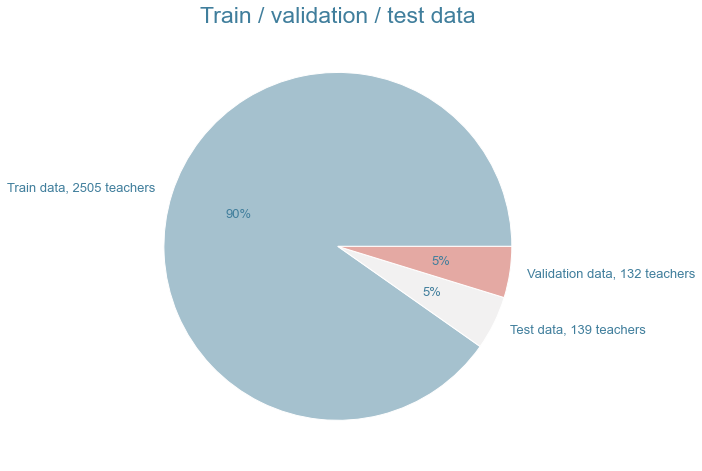

In [12]:
x = [data.shape[0], data_test.shape[0], data_val.shape[0]]
labels = ['Train data', 'Test data', 'Validation data']
labels = [f'{labels[i]}, {x[i]} teachers' for i in range(len(labels))]

colors = [SNS_PALETTE[4], SNS_PALETTE[7], SNS_PALETTE[10]]

print()
pie_plot(x, labels, 'Train / validation / test data', colors)
plt.show()

# 4. EDA (Exploratory Data Analysis).

There can be 4 different types of features: 
- categorical
- numerical
- binary
- text

Prepare lists to separating features.

In [13]:
categorical_columns = []
numerical_columns = []
binary_columns = []
text_columns = []

In [14]:
#Let's add text columns to the prepared list.
text_columns.extend(['about_info','main_info','teacher_style','lessons_style','resume'])

## 4.1. Explore missing data.

Check all data for missing values.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   link              2505 non-null   object 
 1   teacher_type      2505 non-null   object 
 2   is_native         2504 non-null   object 
 3   languages         2505 non-null   object 
 4   about_info        2375 non-null   object 
 5   since_date        2505 non-null   object 
 6   main_info         2505 non-null   object 
 7   country_from      2505 non-null   object 
 8   country_living    2505 non-null   object 
 9   rating            2490 non-null   float64
 10  students_num      2490 non-null   object 
 11  lessons_num       2490 non-null   object 
 12  attendance        2490 non-null   object 
 13  response          2490 non-null   object 
 14  trial             2505 non-null   object 
 15  teacher_style     2466 non-null   object 
 16  lessons_style     2460 non-null   object 


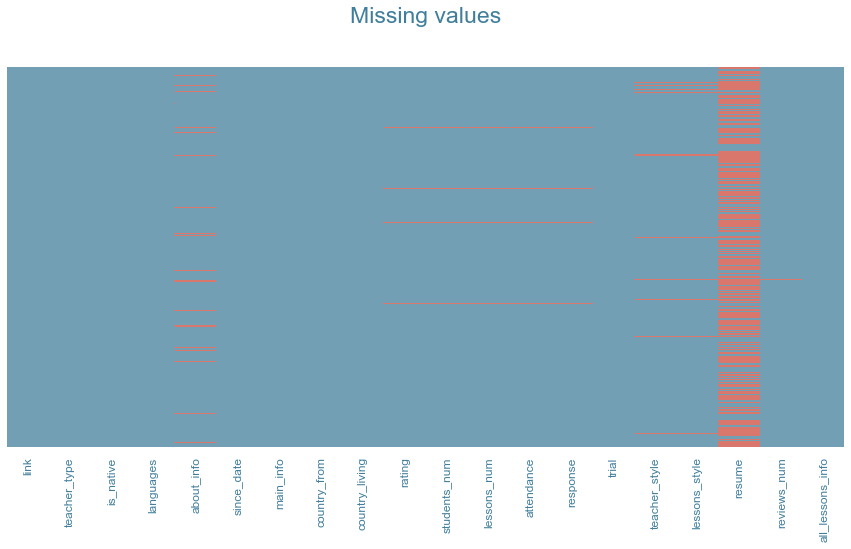

In [16]:
print()
plot_1(figsize=(15,7))

cmap = ListedColormap([SNS_PALETTE[2], SNS_PALETTE[12]])
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap=cmap)

plot_2(title = 'Missing values')
plt.show()

There are several columns with missing data:
 - 'resume' column contains a huge amount of missing data. 
 - 'about_info' column contains a lot of missing data.
 - 'is_native', 'rating', 'students_num', 'lessons_num', 'attendance', 'response', 'teacher_style',
    ' lessons_style', 'reviews_num' columns contain just few missing values.

Let's create new feature  - the share of missing data.

In [17]:
def missing_data(data):
    data['missing_data'] = data.isna().sum(axis=1)/data.shape[1]
    return data

In [18]:
data = missing_data(data)

In [19]:
#add information about missing data as a numerical feature
numerical_columns.append('missing_data')

## 4.2. 'All_lessons_info' column.

This column contains such information about all the lessons that one teacher provides, as:

- Lesson title
- Lesson description
- Lesson categories
- The level of English proficiency required for this lesson
- Number of lessons completed
- Lesson price

We will leave only 60-minute lessons. This will be the target column for the prediction.

In [20]:
#'all_lessons_info' example

data.all_lessons_info[0]

"[['One-on-one English tutoring\\n2,691 Lessons taught\\nLANGUAGE\\nEnglish\\nLEVEL\\nB1 - C2\\nCATEGORY\\nGeneral\\nPronunciation\\nListening\\nWriting\\nDESCRIPTION\\nIn these lessons, I use a variety of tools such as conversation topics, pronunciation guides, articles, and grammar reference materials to help you identify problem areas and improve your English skills.\\nPRICE\\n30 min\\nUSD 10.00\\n45 min\\nUSD 11.00\\n60 min\\nUSD 14.00\\nSome teachers may include a 5 minute break in the lesson time', 'Textbook Guided Lessons\\n10 Lessons taught\\nLANGUAGE\\nEnglish\\nLEVEL\\nA1 - C1\\nCATEGORY\\nGeneral\\nGrammar\\nWriting\\nReading\\nDESCRIPTION\\nUsing textbooks and associated materials, practice your English language skills to advance from beginner through high intermediate/low advanced English with exercises to boost grammar, vocabulary, and fluency.\\nPRICE\\n60 min\\nUSD 20.00\\n90 min\\nUSD 30.00\\nSome teachers may include a 5 minute break in the lesson time']]"

- First, we need to put the information about each lesson on a new row.
- Then we will clean up the information of each lesson and extract useful information.
- After that, we will separate the lesson information into different columns.

In [21]:
# function to separate lessons and create a new DataFrame, where each lesson will be on a new line.
def all_lessons_new_data(data):
    n_rows = data.shape[0]
    
    # Each lesson ends with phrase. 'Some teachers may include a 5 minute break in the lesson time'
    for row in range(n_rows):
        data.all_lessons_info[row] = data.all_lessons_info[row].strip('"[]\'\\n\\')\
            .split('Some teachers may include a 5 minute break in the lesson time')[:-1]

        if len(data.all_lessons_info[row])==0:
            data.all_lessons_info[row] = np.nan
        else:
            for lesson in data.all_lessons_info[row][1:]:
                data = data.append(data.loc[row], ignore_index = True)
                data.all_lessons_info[data.shape[0]-1] = lesson
            data.all_lessons_info[row] = data.all_lessons_info[row][0]
            
    data.dropna(subset = ['all_lessons_info'], inplace = True)
    data = shuffle(data, random_state=RANDOM_STATE)
    data.index = range(data.shape[0])
    
    return data

In [22]:
# For each lesson we extract such information as title, description, category, English proficiency level,
# number of completed lessons, price and organize it in a dictionary.

def lesson_info_prep(lesson_info):
    lesson_dict = {}
    lesson_info = lesson_info.strip('\', "')
    try:
        lesson_dict['TITLE'] = lesson_info.split('\\n')[0]
    except:
        lesson_dict['TITLE'] = np.nan
        
    try:
        lesson_dict['TAUGHT'] = re.sub('[^0-9]+', '', lesson_info.split('\\n')[1])
    except:
        lesson_dict['TAUGHT'] = np.nan
    
    #start from the end

    for info_category in ['PRICE', 'DESCRIPTION','CATEGORY', 'LEVEL', 'LANGUAGE']:
        try:
            lesson_dict[info_category] = lesson_info.split(f'\\n{info_category}\\n')[1]
            lesson_info = ''.join(lesson_info.split(f'\\n{info_category}\\n')[0])
        except:
            lesson_dict[info_category] = np.nan
    
    return lesson_dict

#Extract and keep only 60-minute lessons
def lesson_price_prep(lesson_info):
    price = ' '.join(' '.join(lesson_info['PRICE'].split('\\n')).split(' min USD ')).strip().split(' ')
    keys = [int(k) for k in price[0::2]]
    vals = [float(v) for v in price[1::2]]
    price = dict(zip(keys,vals))
    return price[60]

#Prepare 'main_category' and 'other_categories' columns
def lesson_category_prep(lesson_info):
    try:
        categories = lesson_info['CATEGORY'].split('\\n')
        main_category = categories[0]
        return main_category, categories
    except:
        return np.nan, []
        

In [23]:
#combine all previous functions into one

def all_lesson_info_prep(data):
    data = all_lessons_new_data(data)
    
    data[['description','level','language','title','taught','price','other_categories','main_category']] = np.nan
    
    for row in range(data.shape[0]):
        data.all_lessons_info[row] = lesson_info_prep(data.all_lessons_info[row])
        
        lesson_info = data.all_lessons_info[row]
        data['price'][row] = lesson_price_prep(lesson_info)
        data['main_category'][row], data['other_categories'][row] = lesson_category_prep(lesson_info)
        data['other_categories'][row] = data['other_categories'][row][1:]
        
        for i in ['description', 'level', 'language', 'title', 'taught']:
            try:
                data[i][row] = data.all_lessons_info[row][i.upper()]
            except:
                pass
        
    data = data[data['language'] == 'English']
    data.dropna(subset=['main_category'], inplace=True)
    data.index = range(data.shape[0])

    return data

In [24]:
# train data
data = all_lesson_info_prep(data)

In [25]:
# Add 'title' and 'description' columns as text features
text_columns.extend(['title', 'description'])

### 4.2.1. 'Price' column.

'Price' column will be the target, that we need to predict.

In [26]:
data.price.describe()

count    7571.000000
mean       20.786884
std        11.029977
min         5.000000
25%        13.000000
50%        19.000000
75%        25.000000
max        80.000000
Name: price, dtype: float64

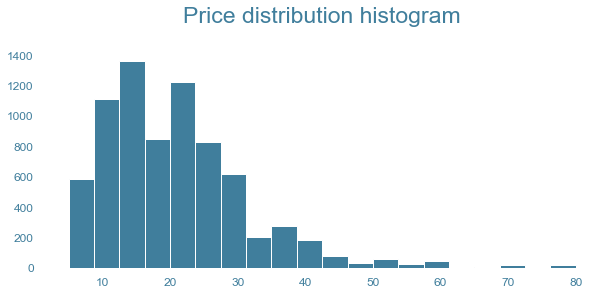

In [27]:
print()
hist_plot(data.price, title='Price distribution histogram')
plt.show()

As we can see, there is a long tail.

### 4.2.2.  'main_category' column.

There are 6 main lesson category options

- Trial
- General
- Conversation Practice
- Business
- Test Preparation
- Kids

We are not going to use Trial lessons, because italki doesn't take 15% commission for this type of lessons and usualy Trial lessons prices don't correlate with the prices of other lessons.

In [28]:
data.main_category.value_counts()

General                  3424
Conversation Practice    2348
Business                  735
Test Preparation          633
Kids                      431
Name: main_category, dtype: int64

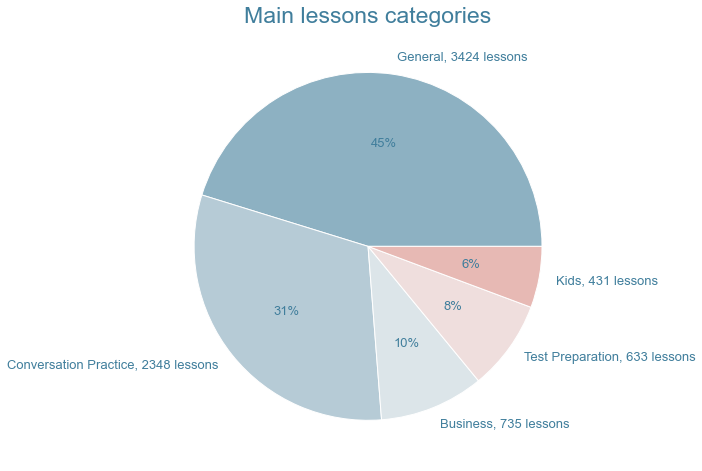

In [29]:
x = list(data.main_category.value_counts().values)
labels = list(data.main_category.value_counts().keys())
labels = [f'{labels[i]}, {x[i]} lessons' for i in range(len(labels))]

colors = sns_palette(n = 10)[2:]

print()
pie_plot(x, labels, 'Main lessons categories', colors)
plt.show()

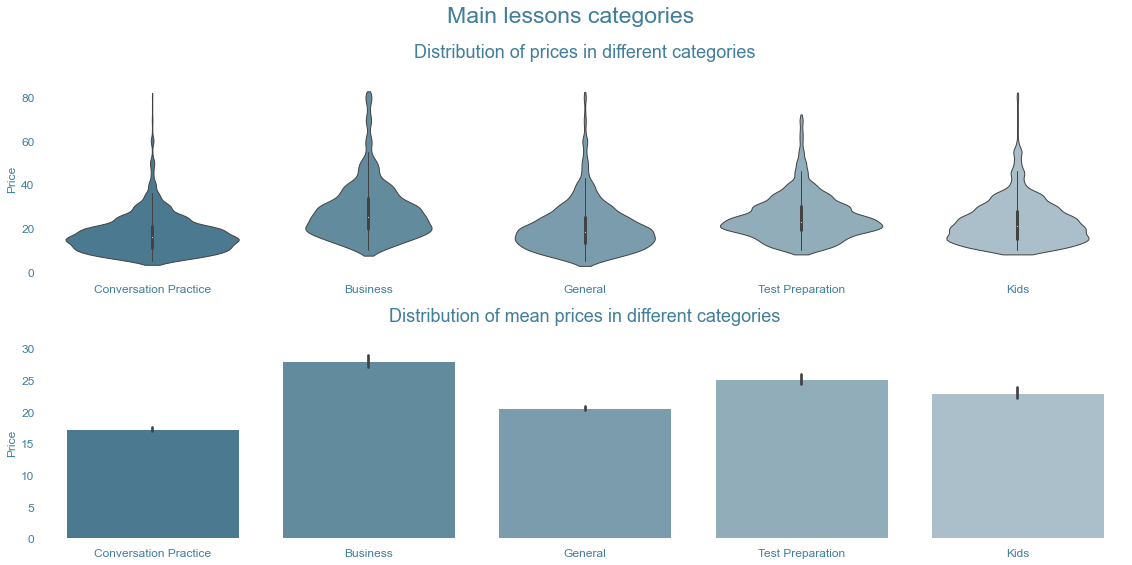

In [30]:
print()

fig = fig_subplot(title = 'Main lessons categories', figsize=(16,8), legend=False)

plt.subplot(2,1,1)
fig.tight_layout(h_pad=2, pad=2)
violin_plot(data, 'main_category', 'price', title = 'Distribution of prices in different categories',
            title_size = 18, palette = SNS_PALETTE, plot=False)  


plt.subplot(2,1,2)
fig.tight_layout(h_pad=4)
bar_plot(data, 'main_category', 'price', title = 'Distribution of mean prices in different categories',
         title_size = 18, palette = SNS_PALETTE, plot=False) 
plt.show()

As we can see, there is a significant difference in the mean prices of lessons for different categories.

In [31]:
categorical_columns.append('main_category')

### 4.2.3. 'other_categories' column.

Let's define other lesson categories and expand binary columns with the most common ones.

In [32]:
#Let's create a list with all categories

category_list_all = sorted(set(data.other_categories.sum()))

In [33]:
#Function to create binary columns with categories
def category_prep(data):
    for category in category_list_all:
        data[category.lower()] = [1 if category in category_list else 0 for category_list in data['other_categories']]
    return data

In [34]:
data = category_prep(data)

In [35]:
# Let's use the lesson category only if it is present in at least 5% of the data.

min_freq = data.shape[0]*0.05
category_list_bin = [col.lower() for col in category_list_all if data[col.lower()].sum() > min_freq]
binary_columns.extend(category_list_bin)

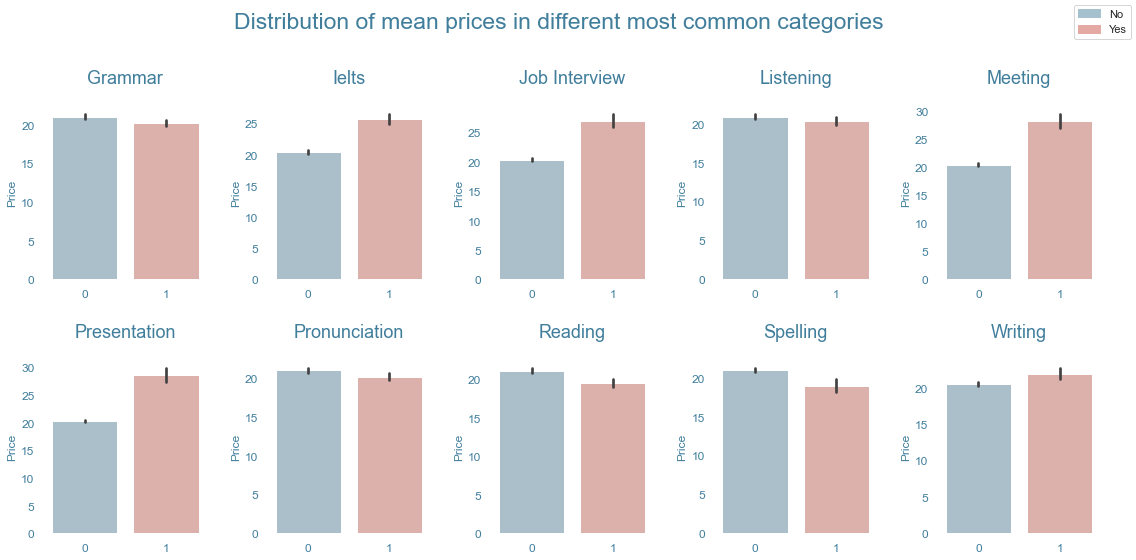

In [36]:
print()
fig_bar_plot(data, category_list_bin, title='Distribution of mean prices in different most common categories',
             figsize=(16,8))
plt.show()

Let's check the correlation of 'other categories' binary columns.

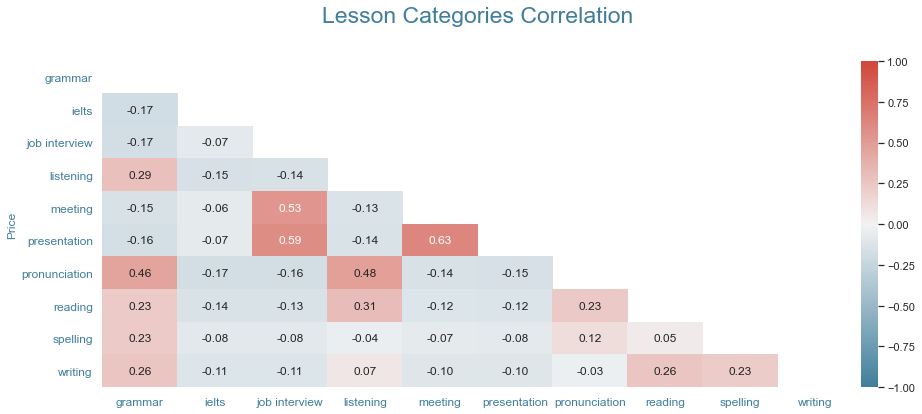

In [37]:
print()
heatmap_plot(data[category_list_bin],'Lesson Categories Correlation' )
plt.show()

We can see, that there are few correlated features. Let's remove the most correlated of them - 'presentation'.

In [38]:
binary_columns.remove('presentation')

### 4.2.4. 'Taught' column.

Number of completed lessons.

In [39]:
data.taught.describe()

count    7571.000000
mean      260.180689
std       557.361758
min         0.000000
25%        11.000000
50%        63.000000
75%       247.000000
max      7266.000000
Name: taught, dtype: float64

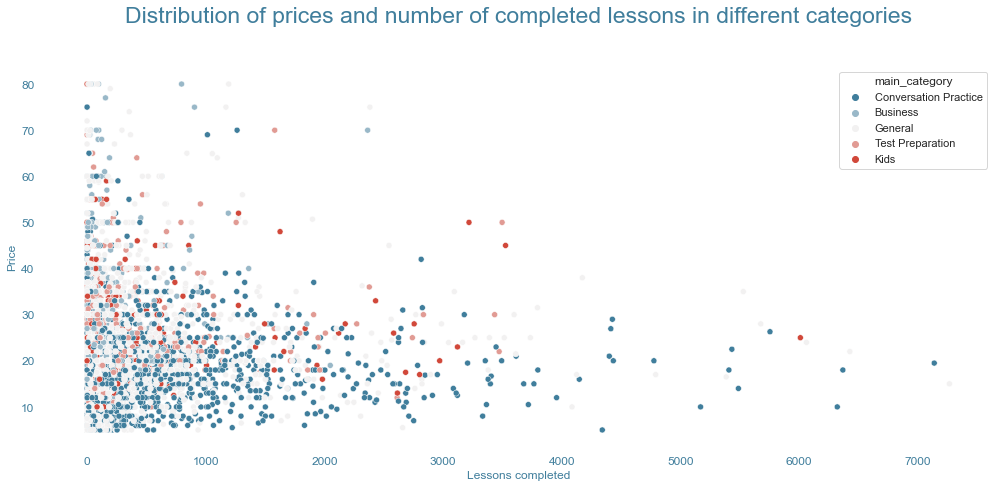

In [40]:
palette = sns_palette(n=5)
cmap = sns_palette(as_cmap=True)

x = data.taught
y = data.price
hue = data.main_category

print()
scatter_plot(x, y, hue, 'Distribution of prices and number of completed lessons in different categories',
             palette=palette, cmap=cmap, xlabel = 'Lessons completed', figsize=(17,7))
plt.show()

Interestingly, there is no strong correlation between the number of lessons taught by teachers and price.

### 4.2.5. 'Level' column.

The level of English proficiency required for this lesson.
Let's add these features as binary.

In [41]:
level_list = ['a1','a2','b1','b2','c1','c2']

#Function to create binary columns with levels
def level_prep(data):
    data[level_list] = 0
    
    for row in range(data.shape[0]):
        level_info = data.level[row]
        if len(level_info) == 2:
            data.level[row]=[level_info.lower()]
        else:
            start = level_info.split(' - ')[0].lower()
            end = level_info.split(' - ')[1].lower()
            data.level[row] = level_list[level_list.index(start):level_list.index(end)+1]
        
        for l in data.level[row]:
            data[l][row] = 1
    
    return data

In [42]:
data = level_prep(data)
binary_columns.extend(level_list)

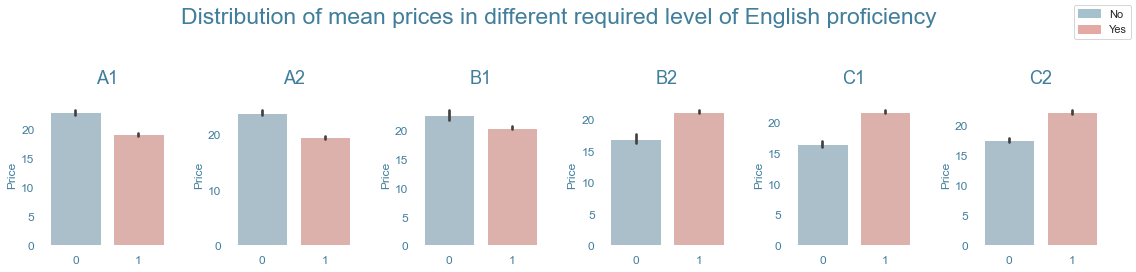

In [43]:
print()
fig_bar_plot(data, level_list,  j=6, 
             title='Distribution of mean prices in different required level of English proficiency', figsize=(16,4))
plt.show()

Let's check the correlation between the required level of English proficiency features.

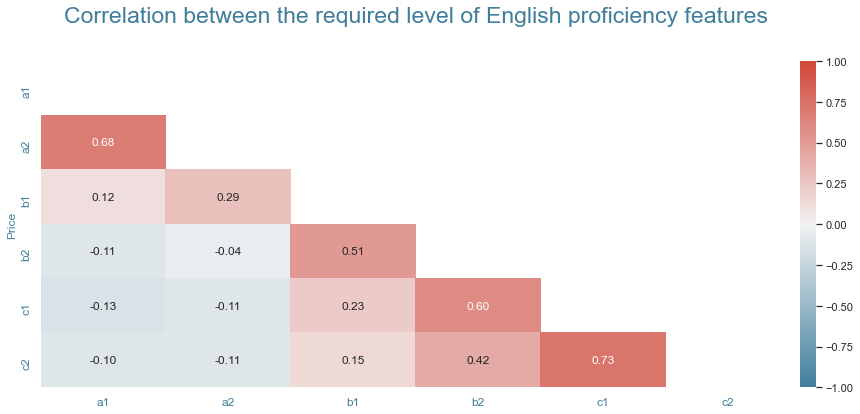

In [44]:
print()
heatmap_plot(data[level_list], 'Correlation between the required level of English proficiency features')
plt.show()

We can see, that there are few correlated features. Let's remove the most correlated of them - 'c2' and 'a2'.

In [45]:
binary_columns.remove('c2')
binary_columns.remove('a2')

## 4.3. 'Teacher type' column.

- Professional Teacher. A highly-skilled and qualified teacher who have experience helping students reach their goals.
- Community Tutor. A native or advanced speaker who helps students through informal tutoring or speaking practice.

In [46]:
data.teacher_type.value_counts()

PROFESSIONAL TEACHER    5187
COMMUNITY TUTOR         2384
Name: teacher_type, dtype: int64

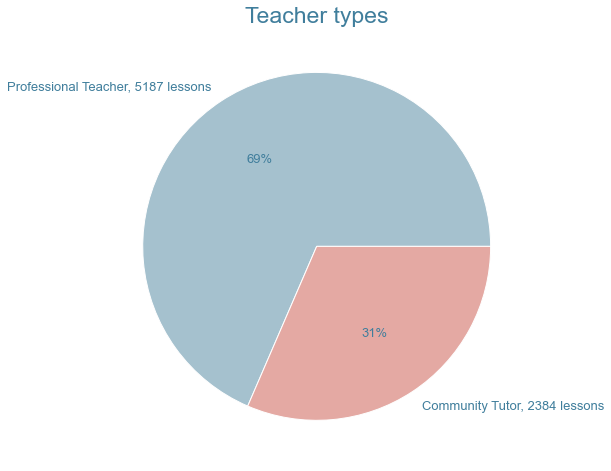

In [47]:
x = list(data.teacher_type.value_counts().values)
labels = [k.title() for k in list(data.teacher_type.value_counts().keys())]
labels = [f'{labels[i]}, {x[i]} lessons' for i in range(len(labels))]

print()
pie_plot(x, labels, 'Teacher types')
plt.show()

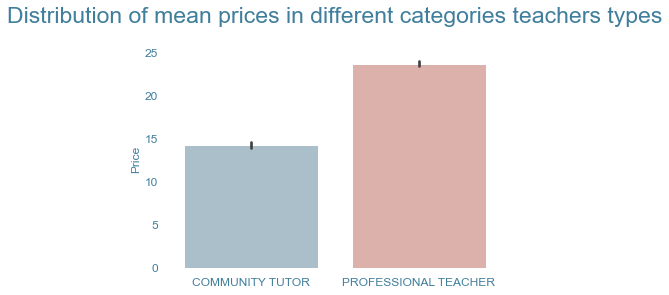

In [48]:
print()
bar_plot(data, 'teacher_type', 'price', title = 'Distribution of mean prices in different categories teachers types', 
         figsize=(6,4))
plt.show()

In [49]:
#There are only 2 values, so let's create function to make this feature binary.

def teacher_type_prep(data):
    data['teacher_type_cat'] = data.teacher_type.copy()
    data['teacher_type'] =  [1 if x == 'PROFESSIONAL TEACHER' else 0 for x in data['teacher_type']]
    return data

In [50]:
data = teacher_type_prep(data)

binary_columns.append('teacher_type')
categorical_columns.append('teacher_type_cat')

## 4.4. 'Is_native' column.
Information about the languages tutor teaches and whether the teacher is a native speaker or not.

In [51]:
data.is_native.value_counts()

Teaches\nEnglish\nNative                                                                         5936
Teaches\nEnglish                                                                                  237
Teaches\nSpanish\nNative\nEnglish                                                                 105
Teaches\nRussian\nNative\nEnglish                                                                  84
Teaches\nEnglish\nNative\nSpanish                                                                  66
                                                                                                 ... 
Teaches\nEnglish\nNative\nTsonga (Xitsonga)\nNative                                                 1
Teaches\nArabic\nNative\nArabic (Egyptian)\nNative\nArabic (Modern Standard)\nNative\nEnglish       1
Teaches\nCroatian\nNative\nEnglish\nNative                                                          1
Teaches\nEnglish\nNative\nFrench\nNative\nPortuguese                              

As we can see, there is a general pattern. We may use this information in different ways.

In [52]:
def teaches_languages_prep(data):
    data['is_native'].fillna('Teaches\nEnglish', inplace=True)
    
    #remove the word 'Teaches'
    is_native_list = [x.split('\n')[1:] for x in data['is_native']]
    
    #prepare a list that will contain lists of all languages taught by the teacher
    teaches_lang_list = []
    
    #prepare a list that will contain lists of all native languages taught by the teacher
    native_lang_list_all = []
    
    for teacher_lang_list in is_native_list:
        teaches_list = set(teacher_lang_list.copy())
        if 'Native' in teaches_list:
            teaches_list.remove('Native')
        teaches_lang_list.append(list(teaches_list))
        
        native_lang_list = []
        for i in range(len(teacher_lang_list)-1):
            if teacher_lang_list[i+1] == 'Native':
                native_lang_list.append(teacher_lang_list[i])
        native_lang_list_all.append(native_lang_list)
        
    #add column with all languages teacher teaches    
    data['teaches_lang_list'] = teaches_lang_list
    
    #add binary column with info if there is just 1 language to teach or more
    data['teaches_lang_list_n'] = [0 if len(x)==1 else 1 for x in teaches_lang_list]
    
    #all native languages
    data['native_lang_list'] = native_lang_list_all

    return data

In [53]:
data = teaches_languages_prep(data)

In [54]:
#Let's define all native languages
all_native_languages = sorted(list(set(data.native_lang_list.sum())))

In [55]:
#Function to create binary columns with native languages
def native_languages_prep(data):
    for language in all_native_languages:
        col_name = f'native_{language}'
        data[col_name] = [1 if language in language_list else 0 for language_list in data.native_lang_list]
    return data

In [56]:
data = native_languages_prep(data)

In [57]:
# Let's use native language only if it is present in at least 5% of the data.

native_lang_bin_columns = [f'native_{language}' for language in sorted(list(set(data.native_lang_list.sum())))]
native_lang_bin_columns = [col for col in native_lang_bin_columns if data[col].sum()>min_freq]

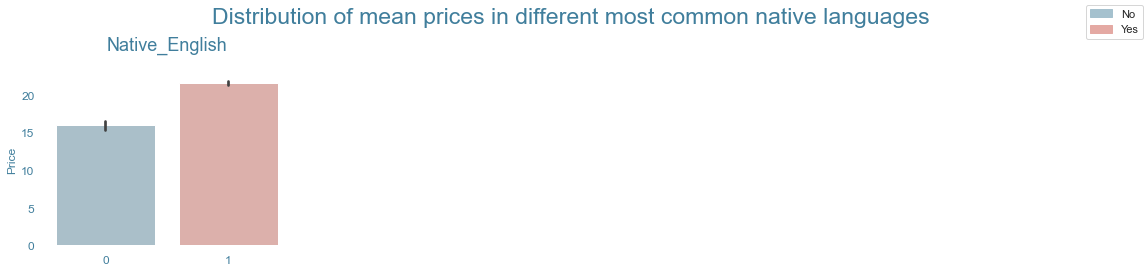

In [58]:
print()
fig_bar_plot(data, native_lang_bin_columns, j=4, 
             title='Distribution of mean prices in different most common native languages', figsize=(16,4))
plt.show()

In [59]:
binary_columns.append('teaches_lang_list_n')
binary_columns.extend(native_lang_bin_columns)

## 4.5. 'Languages' column
List of languages teacher speakes.

In [60]:
data.languages.value_counts()

['Other']                                                                                                   953
['Spanish']                                                                                                 453
[]                                                                                                          226
['Spanish', 'Other']                                                                                        216
['French']                                                                                                  167
                                                                                                           ... 
['Arabic (Egyptian)', 'Arabic (Modern Standard)', 'Chinese (Mandarin)', 'German', 'Romanian', 'Spanish']      1
['Arabic (Levantine)', 'Spanish', 'Urdu', 'Russian', 'Japanese', 'Tajik']                                     1
['Spanish', 'Arabic (Egyptian)', 'French']                                                              

In [61]:
def other_languages_prep(data):
    #Converting data to list format
    data['other_languages_list'] = [re.sub('[^a-zA-Z, ]+', '', x) for x in data.languages]
    data['other_languages_list'] = [x.split(', ') if x!='' else [] for x in data['other_languages_list']]
    
    #Let's add all the languages taught by the teachers
    data['other_languages_list'] = data['other_languages_list'] + data['teaches_lang_list']

    #Let's create binary columns with other languages
    all_other_languages = sorted(list(set(data.other_languages_list.sum())))

    for language in all_other_languages:
        col_name = f'other_{language.lower()}'
        data[col_name] = [1 if language in language_list else 0 for language_list in data.other_languages_list]
        
    return data

In [62]:
data = other_languages_prep(data)

In [63]:
# Let's use native language only if it is present in at least 5% of the data.
other_lang_bin_columns = [f'other_{language.lower()}' 
                        for language in sorted(list(set(data.other_languages_list.sum())))]
other_lang_bin_columns = [col for col in other_lang_bin_columns if data[col].sum() > min_freq]

In [64]:
#Remove useless columns - "other_english" because all teachers speak it, and "other_other"

other_lang_bin_columns.remove('other_other')
other_lang_bin_columns.remove('other_english')

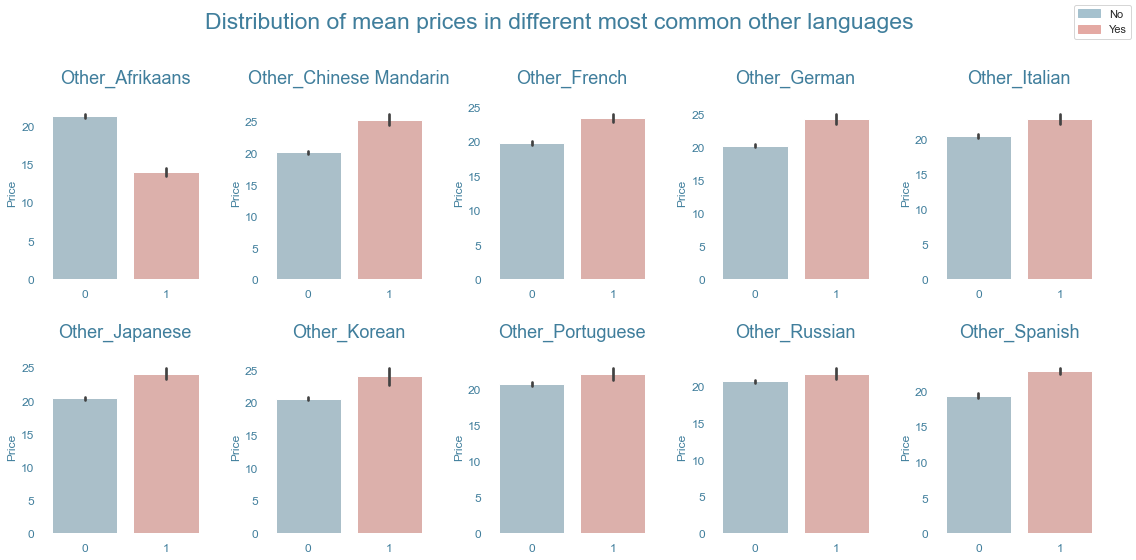

In [65]:
print()
fig_bar_plot(data, other_lang_bin_columns, 
             title='Distribution of mean prices in different most common other languages', figsize=(16,8))
plt.show()

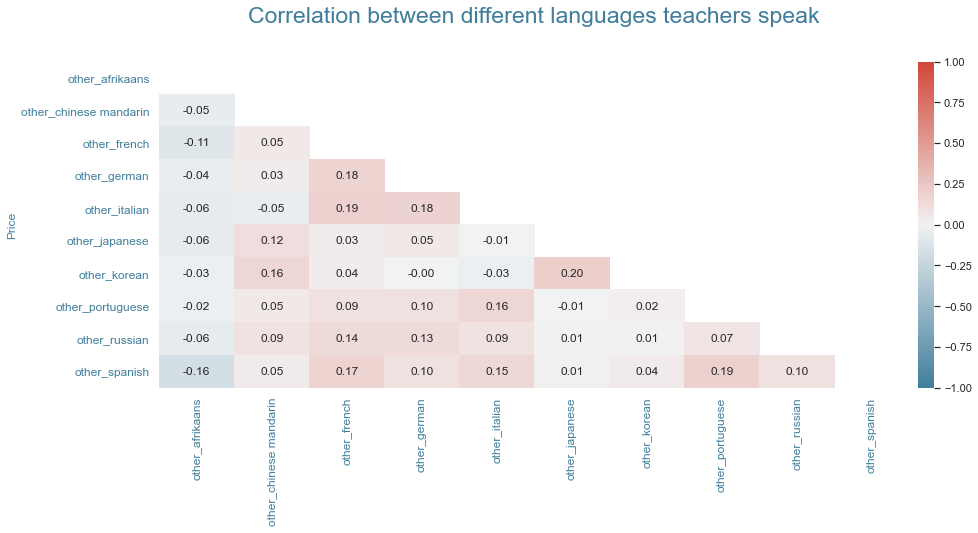

In [66]:
print()
heatmap_plot(data[other_lang_bin_columns], 'Correlation between different languages teachers speak')
plt.show()

In [67]:
binary_columns.extend(other_lang_bin_columns)

## 4.6. 'Since_date' column
Teacher has joined italki since that date.

In [68]:
data.since_date.values

array(['italki teacher since May 24, 2018',
       'italki teacher since Apr 13, 2022',
       'italki teacher since Apr 13, 2020', ...,
       'italki teacher since Jul 2, 2021',
       'italki teacher since Mar 5, 2023',
       'italki teacher since Feb 16, 2017'], dtype=object)

In [69]:
def since_date_prep(data):
    # Convert data to date format
    data.since_date = [' '.join(list(np.array(x.split(' '))[[3,5]])) for x in data.since_date.values]
    data.since_date = data.since_date.apply(pd.to_datetime)

    #Let's divide teachers into 2 categories - who joined before 2020 or later
    data['year'] = [date.year for date in data.since_date]
    data['year'] = [1 if y>2019 else 0  for y in data.year]
    return data

In [70]:
data = since_date_prep(data)
binary_columns.append('year')

In [71]:
data.year.value_counts()

1    5458
0    2113
Name: year, dtype: int64

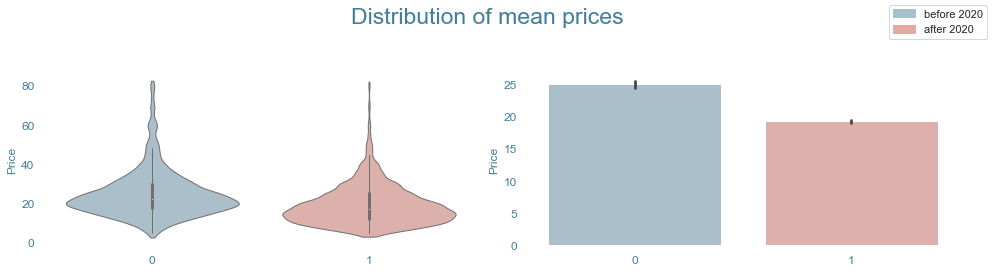

In [72]:
print()

colors = {'before 2020': COLOR_1, 'after 2020': COLOR_2}    

fig = fig_subplot(title = 'Distribution of mean prices', colors=colors, figsize=(14,4))

plt.subplot(1,2,1)
fig.tight_layout(h_pad=2, pad=2)
violin_plot(data, 'year', 'price', title_size = 18, plot=False)  

plt.subplot(1,2,2)
fig.tight_layout(h_pad=2, pad=2)
bar_plot(data, 'year', 'price', title_size = 18, plot=False)      

plt.show()

## 4.7. 'Country_from' and 'country_living' columns

'country_from' - The country where the teacher is from.

'country_living' - The country in which the teacher lives now.

In [73]:
def country_from_prepare(data):
    data.country_from = [x.split('From ')[1] for x in data.country_from]
    
    return data
    
def country_living_prepare(data):
    #Let's extract the UTC difference for each teacher
    data['utc_diff'] = [x.split('UTC')[1].split(':')[0] for x in data.country_living]
    data.utc_diff = data.utc_diff.astype('int')
    
    return data

# Let's combine 2 functions into one
def countries_prep(data):
    data = country_from_prepare(data)
    data = country_living_prepare(data)
    
    return data

In [74]:
data = countries_prep(data)
categorical_columns.extend(['country_from', 'utc_diff'])

In [75]:
#Let's use a country only if there are at least 100 rows with it in the data.

country_from_dict = dict(data['country_from'].value_counts())
country_from_most_common = list(dict(filter(lambda elem: elem[1]>100, country_from_dict.items())).keys())

#Function to leave only the most common countries
def most_common_countries_prep(data):
    data['country_from'] = [x if x in country_from_most_common else 'Other' for x in data['country_from']]
    
    return data

In [76]:
data = most_common_countries_prep(data)

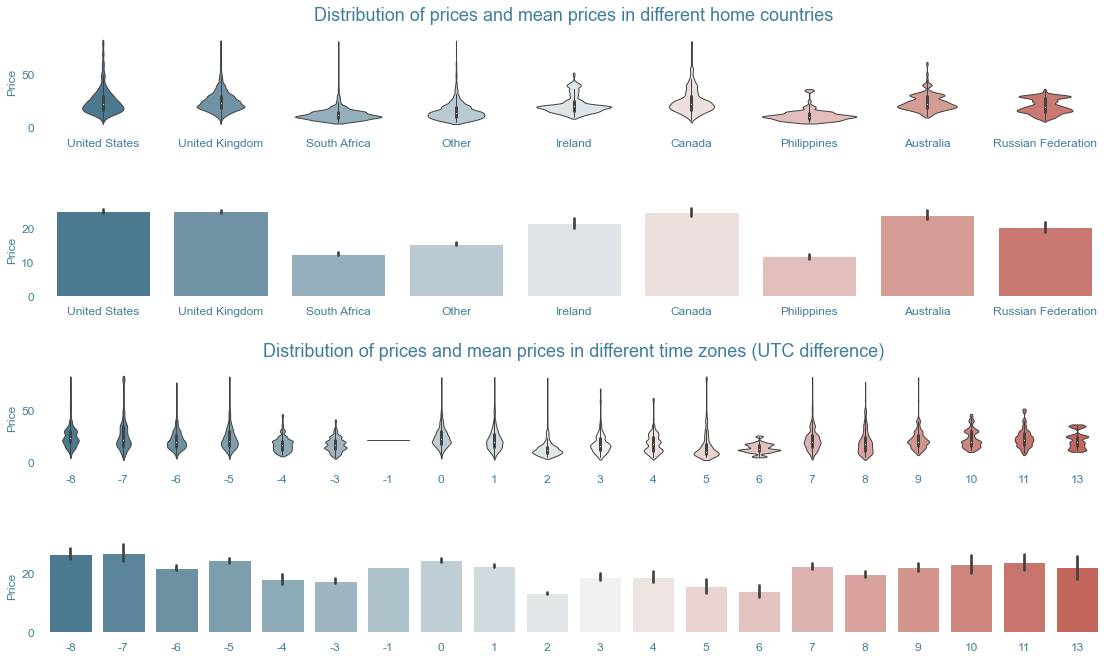

In [77]:
print()

columns_list = ['country_from', 'utc_diff']
titles_list = ['home countries', 'time zones (UTC difference)']

palette = sns_palette(n = max(len(country_from_most_common), len(data.utc_diff.unique()))+1)

fig = fig_subplot(figsize=(16,10), legend=False)

title_start = 'Distribution of prices and mean prices in different'
row = 1
for i in range(2):
    
    plt.subplot(4,1,row)
    fig.tight_layout(h_pad=2, pad=2)
    violin_plot(data, x=columns_list[i], y = 'price', title = f'{title_start} {titles_list[i]}',
                palette=sns_palette(n = len(data[columns_list[i]].unique())+1), title_size=18, plot=False)
    
    plt.subplot(4,1,row+1)
    fig.tight_layout(h_pad=2, pad=2)
    bar_plot(data, columns_list[i], 'price', palette=sns_palette(n = len(data[columns_list[i]].unique())+1), 
             plot=False)
    row+=2
plt.show()

## 4.8. 'Rating' column.

Teacher rating.

In [78]:
data.rating.value_counts()

5.0    5693
4.9    1551
4.8     242
4.7      41
4.6       9
4.4       3
4.5       2
4.3       1
4.2       1
Name: rating, dtype: int64

In [79]:
data.rating.fillna(5.0, inplace=True)

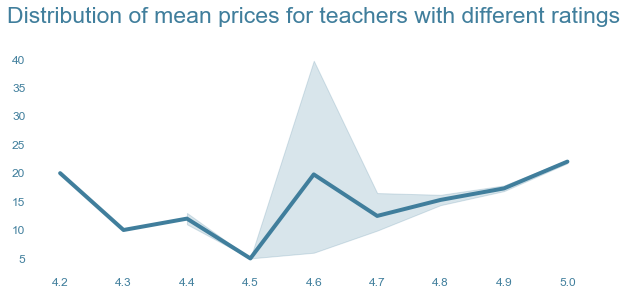

In [80]:
print()
line_plot(data.rating, data.price, 'Distribution of mean prices for teachers with different ratings')
plt.show()

In [81]:
#Let's combine all ratings below 5.0.

def rating_prep(data):
    data.rating.fillna(5.0, inplace=True)
    data['rating'] = [x if x==5.0 else 4.9 for x in data['rating']]
    return data

In [82]:
data = rating_prep(data)

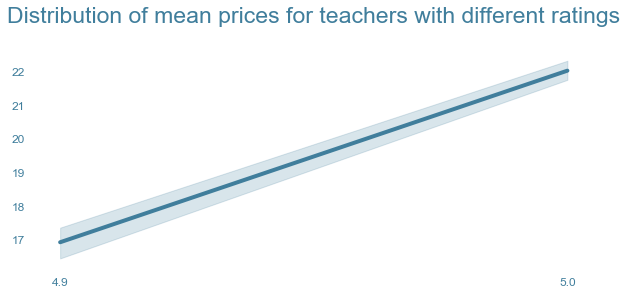

In [83]:
print()
line_plot(data.rating, data.price, 'Distribution of mean prices for teachers with different ratings', 
          xticks=True)
plt.show()

In [84]:
numerical_columns.append('rating')

## 4.9. 'Students_num', 'lessons_num', 'attendance', 'response', 'reviews_num' columns.
'students_num' - Number of students of teachers. <br/>
'lessons_num' - Number of lessons of teachers. <br/>
'attendance' - Percentage of teacher attendance. <br/>
'response' - Percentage of teacher response. <br/>
'reviews_num' - Number of reviews.

In [85]:
num_cols = ['students_num', 'lessons_num', 'attendance', 'response', 'reviews_num']
data[num_cols].head()

,students_num,lessons_num,attendance,response,reviews_num
0,175,929,100%,100%,70 Reviews
1,32,106,99%,100%,5 Reviews
2,362,"3,319",100%,100%,232 Reviews
3,284,631,100%,100%,74 Reviews
4,150,971,100%,99%,70 Reviews


In [86]:
#Convert data in num_cols to number format.
def num_cols_prep(data):
    for col in num_cols:
        data[col].fillna(0, inplace=True)
        data[col] = data[col].astype('str')
        data[col] = [x.replace('k', '000') for x in data[col]]
        data[col] = [re.sub('[^0-9]+', '', x) for x in data[col]]
        data[col] = [x if x!='' else 0 for x in data[col]]
        data[col] = data[col].astype('int')
    data['attendance'] = [x if x > 99 else 99 for x in data['attendance']]
    data['response'] = [x if x > 99 else 99 for x in data['response']]
    
    #Create new feature - average number of lessons per student
    data['st_les'] = data['lessons_num']/data['students_num']
    data['st_les'].fillna(0, inplace=True)
    
    return data

In [87]:
data = num_cols_prep(data)
numerical_columns.extend(num_cols)
numerical_columns.append('st_les')

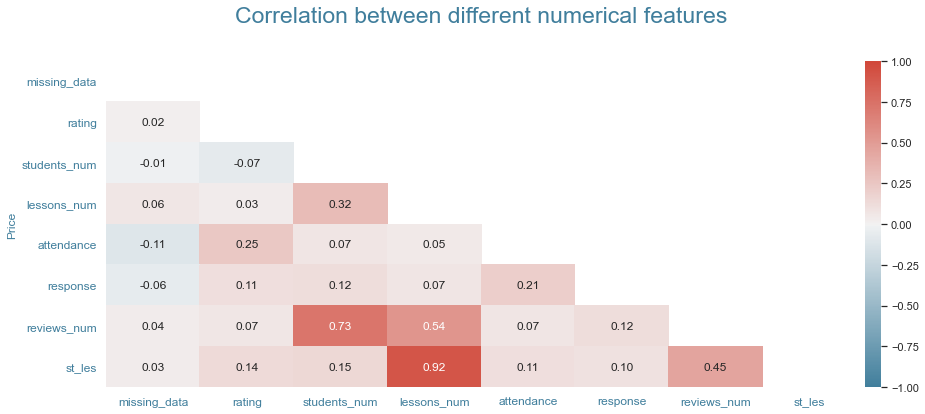

In [88]:
print()
heatmap_plot(data[numerical_columns], 'Correlation between different numerical features')
plt.show()

We can see, that there are few correlated features. Let's remove the most correlated of them - 'lessons_num' and 'reviews_num'.

In [89]:
numerical_columns.remove('lessons_num')
numerical_columns.remove('reviews_num')

## 4.10. Text columns preparation.

In [90]:
data[text_columns].head()

,about_info,main_info,teacher_style,lessons_style,resume,title,description
0,My native languages are Italian and English. I...,English Conversation Tutor,Education:\n\nTEFL certificate\nTESOL Certific...,My specialties:\n-Everyday English conversatio...,NaN,English Conversation,For upper intermediate level (B2) students and...
1,"My name is David and I am British, so a native...","English pronunciation, British accent, Busines...",I have been teaching English to students both ...,"For me, it is most important to put my student...",TEFL UK TEFL 2019\nCertified in Teaching Engli...,Legal English,Learn legal English related to matters such as...
2,"I'm an American from Seattle, Washington curre...",Certified English Teacher With Over 7 Years of...,"Teaching is my passion, and it's the path that...","As I've taught in many different courses, I've...",2016 - 2018\nEnglish Teacher Yazigi\nYazigi - ...,Private Book Club,This is a class that I created for my more adv...
3,"Former Lawyer, I now focus on: English and Bus...","Retired from Legal Practice, Now Qualified Tea...",I will use proven strategies to take you forwa...,We'll talk about the things that hold you back...,1991 - 2019\nEmployed solicitor Insurance Indu...,General English for Intermediate and Advanced ...,I have had a great experience teaching General...
4,"I am a teacher, traveller and professional pho...","I am a teacher, traveller and professional pho...",I have been teaching English here in Bogota fo...,My teaching style is responsive to your needs....,2018 - 2022\nTeacher Profesores Extranjeros\nP...,Conversational English - quickly develop your ...,"Learn, practice and refine your use of the Eng..."


In [91]:
data[text_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7571 entries, 0 to 7570
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   about_info     7242 non-null   object
 1   main_info      7571 non-null   object
 2   teacher_style  7452 non-null   object
 3   lessons_style  7431 non-null   object
 4   resume         3790 non-null   object
 5   title          7571 non-null   object
 6   description    7557 non-null   object
dtypes: object(7)
memory usage: 414.2+ KB


In [92]:
#There are many teachers who have the same information in 2 columns.
print(data[data.about_info == data.main_info].shape[0])

1728


In [93]:
text_columns_new = ['lesson_text_info', 'teacher_text_info']

In [94]:
#Let's leave only 2 text features - 1 for information about the teacher and 1 for information about the lesson
def about_info_prep(data):

    data['about_info'] = [data['about_info'][i] if data['about_info'][i] == data['main_info'][i]
                        else data['about_info'][i] + ' ' + data['main_info'][i] for i in range(data.shape[0])]
    
    data['teacher_text_info'] = data['about_info'] + ' ' + data['teacher_style'] + ' ' + data['lessons_style'] +\
                        ' ' + data['resume']
    
    data['lesson_text_info'] = data['description'] + ' ' + data['title']
    
    return data


def prepare_text_feature(data, column):
    data[column] = [re.sub(r'\\n', '', s) for s in data[column]]
    data[column] = [re.sub('[^A-Za-z1-9]', ' ', s) for s in data[column]]
    data[column] = [x.strip().lower() for x in data[column]]
    
    return data

    
def text_columns_prep(data):
    data[text_columns] = data[text_columns].fillna('')
    data = about_info_prep(data)

    for column in text_columns_new:
        data = prepare_text_feature(data, column)
    
    return data

In [95]:
data = text_columns_prep(data)

## 4.11. Columns correlation.

### Let's check binary columns correlation

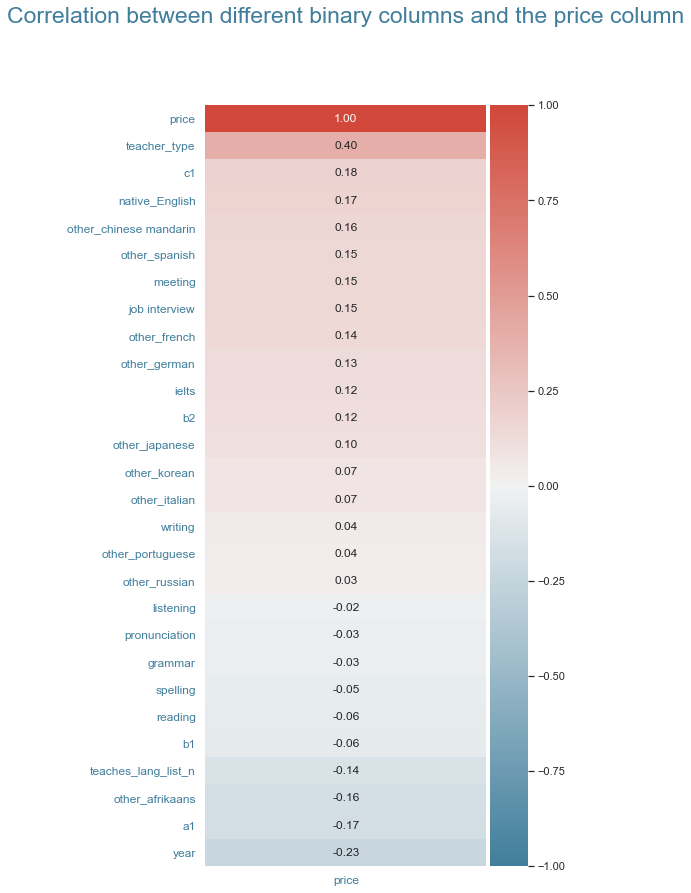

In [96]:
#Check the correlation between different binary columns and the price column.

dataframe = pd.concat([data[binary_columns], data.price], axis=1)

print()
plot_1(figsize=(6, 14))
heatmap = sns.heatmap(dataframe.corr()[['price']].sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap=CMAP, fmt='.2f', cbar=True, 
                      cbar_kws = {'shrink': 1,'pad':0.01})
plot_2('Correlation between different binary columns and the price column')
plt.show()

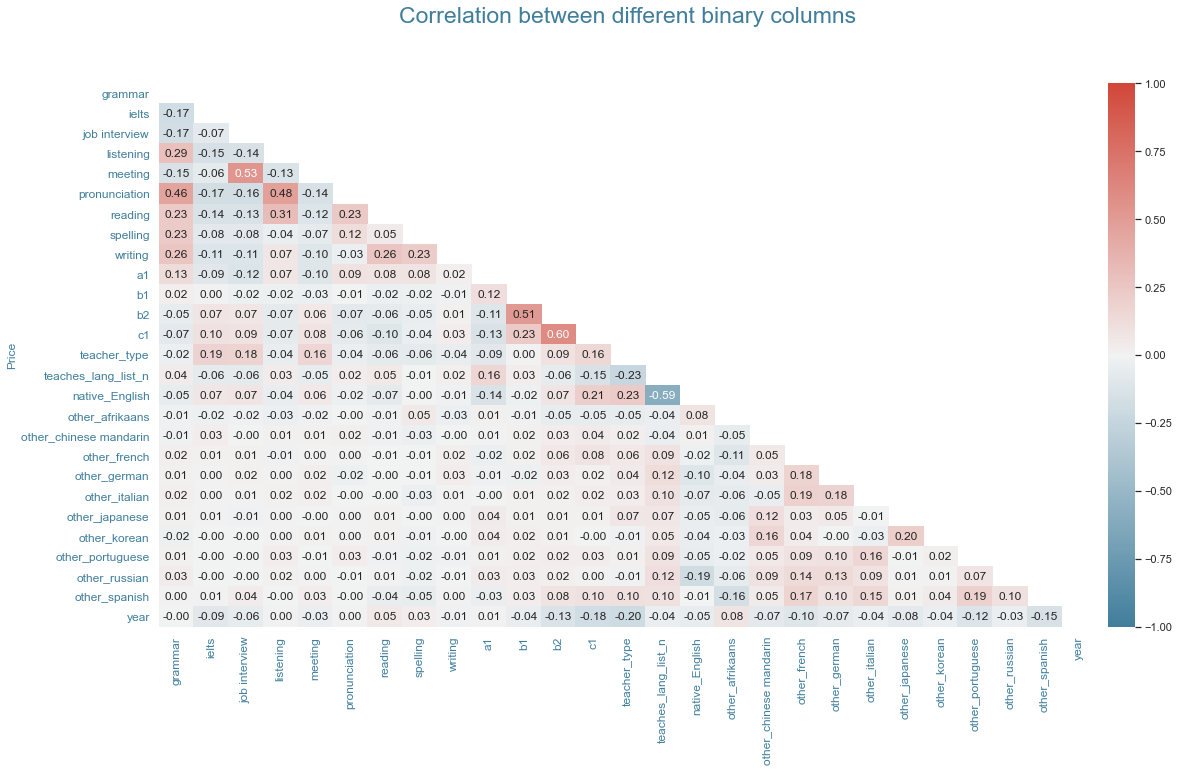

In [97]:
print()
heatmap_plot(data[binary_columns], 'Correlation between different binary columns', figsize=(20,10))
plt.show()

### Let's check the numerical columns correlation

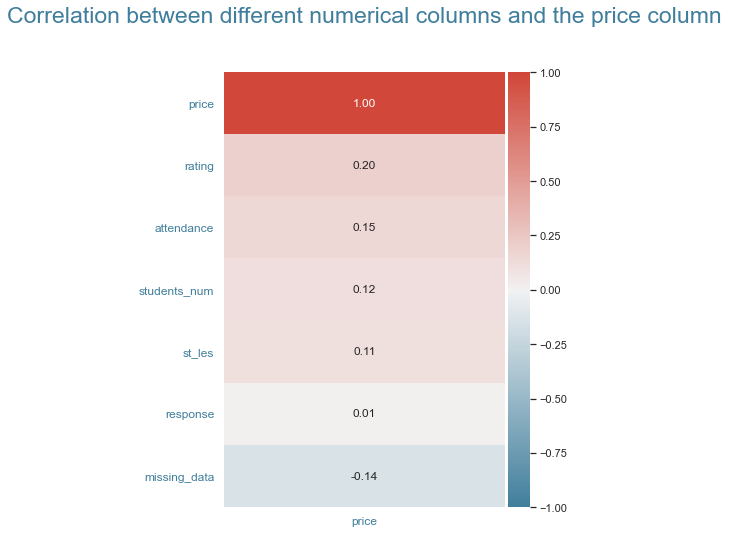

In [98]:
#Check the correlation between different numerical columns and the price column.

dataframe = pd.concat([data[numerical_columns], data.price], axis=1)

print()
plot_1(figsize=(6, 8))
heatmap = sns.heatmap(dataframe.corr()[['price']].sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap=CMAP, fmt='.2f', cbar=True, 
                      cbar_kws = {'shrink': 1,'pad':0.01})
plot_2('Correlation between different numerical columns and the price column')
plt.show()

Let's remove the least correlated feature - "response".

In [99]:
numerical_columns.remove('response')

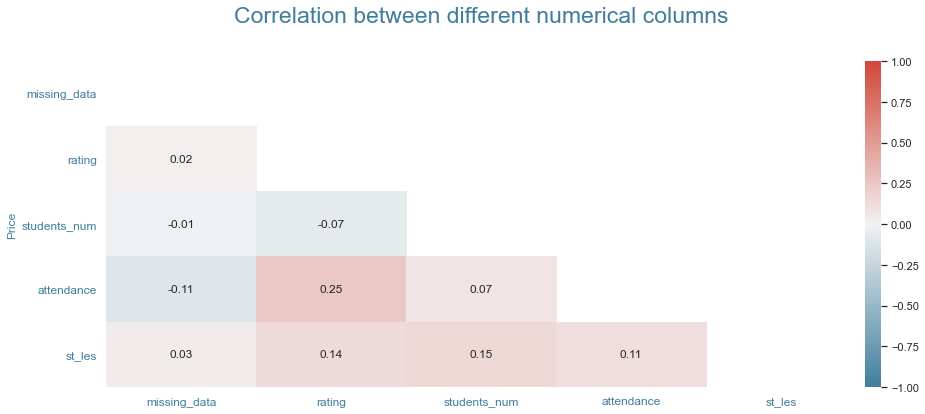

In [100]:
print()
heatmap_plot(data[numerical_columns], 'Correlation between different numerical columns')
plt.show()

# 5. Validation data preparation.

In [101]:
#Function for new data preparation.

def all_data_prep(data):
    data = missing_data(data)
    data = all_lesson_info_prep(data)
    data = category_prep(data)
    data = level_prep(data)
    data = teacher_type_prep(data)
    data = teaches_languages_prep(data)
    data = native_languages_prep(data)
    data = other_languages_prep(data)
    data = since_date_prep(data)
    data = countries_prep(data)
    data = most_common_countries_prep(data)
    data = rating_prep(data)
    data = num_cols_prep(data)
    data = text_columns_prep(data)
    return data

In [102]:
#Let's prepare the validation data.
data_val = all_data_prep(data_val)

# 6. Separate the most expensive lessons.

In [103]:
data.price.describe()

count    7571.000000
mean       20.786884
std        11.029977
min         5.000000
25%        13.000000
50%        19.000000
75%        25.000000
max        80.000000
Name: price, dtype: float64

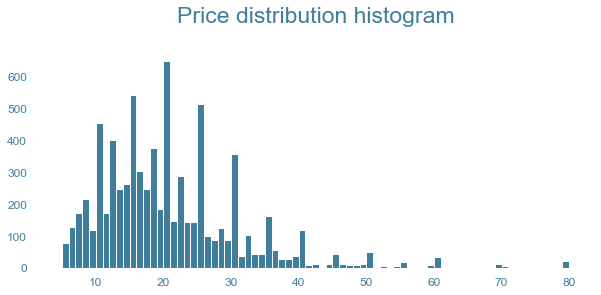

In [104]:
n = int(data.price.max() - data.price.min())

print()
hist_plot(data.price, title='Price distribution histogram', n=n)
plt.show()

In [105]:
#As we can see there is a long tail in the price distribution. Let's separate the most expensive lessons.
#Determine the 5% quantile.
q = data.price.quantile(0.95)

print(f'95% quantile price is {q}.')

data_top_5 = data[data.price >= q]
data = data[data.price < q]
data.index = range(data.shape[0])

95% quantile price is 40.0.


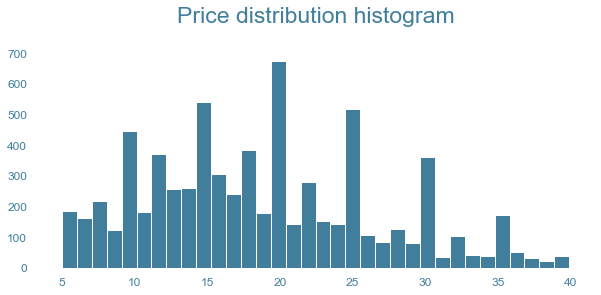

In [106]:
n = int(data.price.max() - data.price.min())

print()
hist_plot(data.price, title='Price distribution histogram', n=n)
plt.show()

In [107]:
#Let's separate the most expensive lessons in validation data.
data_top_5= data_top_5.append(data_val[data_val.price >= q], ignore_index=True)

data_val = data_val[data_val.price < q]
data_val.index = range(data_val.shape[0])

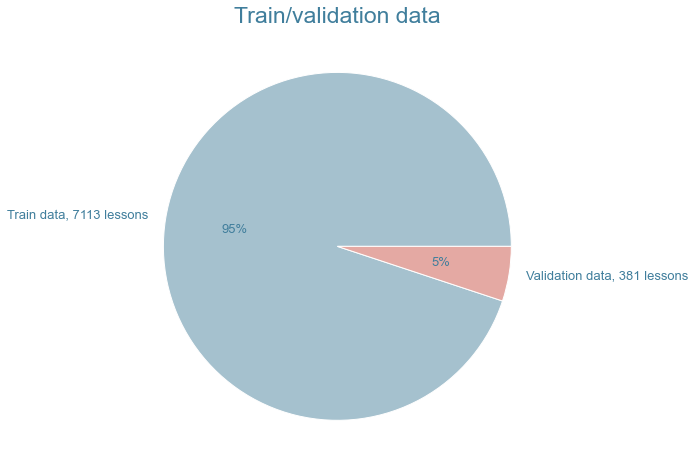

In [108]:
#Let's check if the proportion is still 95% train data / 5% validation data
print()

x = [data.shape[0], data_val.shape[0]]
labels = ['Train data', 'Validation data']
labels = [f'{labels[i]}, {x[i]} lessons' for i in range(len(labels))]

pie_plot(x, labels, 'Train/validation data')
plt.show()

In [109]:
print(f'Train data shape {data.shape} with mean lesson price {data.price.mean()}')
print(f'Validation data shape {data_val.shape} with mean lesson price {data_val.price.mean()}')

Train data shape (7113, 345) with mean lesson price 18.87014902291579
Validation data shape (381, 251) with mean lesson price 18.84593175853018


Let's prepare a dictionary for the final report

In [110]:
report = {}

In [111]:
report['Mean lesson price in train data'] = data.price.mean()
report['Mean lesson price in validation data'] = data_val.price.mean()

# 7. Text data predictions

In [112]:
text_columns_new

['lesson_text_info', 'teacher_text_info']

We have 2 text columns with information about the teacher and the lesson. Let's create a function, that will transform the text into a predicted lesson price.

In [113]:
#In this function for testing, we will use validation and test data depending on what we need.
def text_preds(train, test, target_train, target_test, column):

    #To have more sustainable predictions, let's fit several models and average the result.
    preds_num_cols = []

    train_preds = np.zeros((train.shape[0], 0))
    test_preds = np.zeros((test.shape[0], 0))

    if column == 'lesson_text_info':
        C = 0.5
    else:
        C = 0.1

    models = []
    models.append(Ridge(max_iter=25, alpha=50, random_state=RANDOM_STATE))
    models.append(Ridge(max_iter=25, alpha=60, random_state=RANDOM_STATE))

    models.append(LinearSVR(max_iter=25, C=C, random_state=RANDOM_STATE))
    models.append(LinearSVR(max_iter=25, C=C, random_state=RANDOM_STATE_2))

    for model in models:
        estimator = Pipeline(
                [("vect", CountVectorizer(stop_words='english', ngram_range=(3,5), analyzer='char_wb')),
                ("transformer",  TfidfTransformer()),
                ("regressor", model)])

        estimator.fit(train[column], target_train)
        train_preds_add = estimator.predict(train[column])
        test_preds_add = estimator.predict(test[column])

        print(f'{column.title()} mean absolute error train {mean_absolute_error(target_train, train_preds_add)}')
        print(f'{column.title()} mean absolute error test {mean_absolute_error(target_test, test_preds_add)}')
        print('---')

        train_preds = np.append(train_preds, train_preds_add.reshape((train.shape[0], 1)), axis=1)
        test_preds = np.append(test_preds, test_preds_add.reshape((test.shape[0], 1)), axis=1)

    train_preds_mean = train_preds.mean(axis=1)
    test_preds_mean = test_preds.mean(axis=1)    
    
    #Let's add columns with predictions to the train and test data.
    col_name = f'{column}_preds'
    train[col_name] = train_preds_mean
    test[col_name] = test_preds_mean

    print('----------------------------------------')
    print()
    print(f'Combined {column.title()} mean absolute error for train data {mean_absolute_error(target_train,train_preds_mean)}')
    print(f'Combined {column.title()} mean absolute error for test data {mean_absolute_error(target_test,test_preds_mean)}')
    print('----------------------------------------')
    print()

In [114]:
for column in text_columns_new:
    text_preds(data, data_val, data.price, data_val.price, column)
    numerical_columns.append(f'{column}_preds')

Lesson_Text_Info mean absolute error train 5.774414049247955
Lesson_Text_Info mean absolute error test 5.443105485544974
---
Lesson_Text_Info mean absolute error train 5.820855676130036
Lesson_Text_Info mean absolute error test 5.487008933945514
---
Lesson_Text_Info mean absolute error train 5.267640511577077
Lesson_Text_Info mean absolute error test 5.165838363161457
---
Lesson_Text_Info mean absolute error train 5.267574126002182
Lesson_Text_Info mean absolute error test 5.165445533566241
---
----------------------------------------

Combined Lesson_Text_Info mean absolute error for train data 5.51072578254708
Combined Lesson_Text_Info mean absolute error for test data 5.263113202837815
----------------------------------------

Teacher_Text_Info mean absolute error train 5.317853607472926
Teacher_Text_Info mean absolute error test 5.131025869526177
---
Teacher_Text_Info mean absolute error train 5.415827815824018
Teacher_Text_Info mean absolute error test 5.210211214449134
---
Teache

# 8. Model selection.

In [115]:
#Let's create a function to concatinate numerical, categorical and binary features.
def X_concat(data):
    return pd.concat([data[numerical_columns], data[categorical_columns], data[binary_columns]], axis=1)

#Function to scale numerical features
def scaler_numerical_features(train, test):
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return train, test

def all_data_conacat(train, test):
    X_train = X_concat(train)
    
    #Identify columns that are not in the test dataset
    columns_to_add = sorted(list(set(X_train.columns) - set(test.columns)))
    test[columns_to_add] = 0
    X_test = X_concat(test)
    
    X_train[numerical_columns], X_test[numerical_columns] = scaler_numerical_features(X_train[numerical_columns], 
                                                                                      X_test[numerical_columns])

    y_train = train.price
    y_test = test.price
    
    return X_train, X_test, y_train, y_test

In [116]:
X_train, X_val, y_train, y_val = all_data_conacat(data, data_val)

In [117]:
#Define the test parameters to find the best result

parameters_grid = {
    'learning_rate' : [0.001, 0.005],
    'loss_function': ['RMSE','MAE'],
    'n_estimators':[1500, 2000],  
    'max_depth':[5, 6], 
    'subsample':[0.5, 0.75]
}

In [118]:
X = X_train.append(X_val, ignore_index=True)
y = np.concatenate((y_train, y_val))

#Due to the fact that we shouldn't shuffle train and validating data, we need to define a cv strategy 
cv = [(list(range(data.shape[0])), list(range(data.shape[0], X.shape[0])))]

pipeline = CatBoostRegressor(cat_features=categorical_columns, silent=True, random_state=RANDOM_STATE)
grid_cv = GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=cv)
grid_cv.fit(X, y)
best_estimator = grid_cv.best_estimator_

print(f'Best score: {grid_cv.best_score_}.')

Best score: -3.7496789816459355.


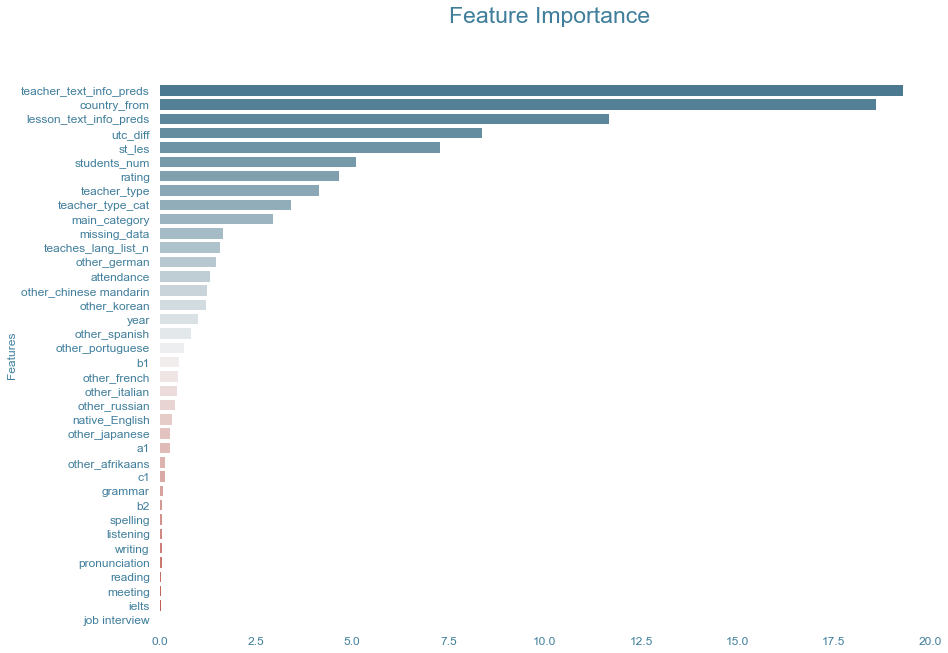

In [119]:
print()
importance = pd.DataFrame({'feature':X_train.columns, 'importance': best_estimator.feature_importances_})
importance.sort_values('importance',ascending=False, inplace=True)

palette = sns_palette(n = importance.shape[0])
bar_plot(data = importance, x ='importance', y = 'feature', title = 'Feature Importance',
            palette = palette, ylabel='Features', figsize=(14,10))
plt.show()

In [120]:
#Let's see the best parameters of the model
best_estimator_params = dict([i for i in best_estimator.get_params().items()])
[print(f'{k} - {v}') for k, v in best_estimator_params.items()]
print()

learning_rate - 0.005
loss_function - MAE
silent - True
subsample - 0.75
max_depth - 6
n_estimators - 2000
random_state - 27
cat_features - ['main_category', 'teacher_type_cat', 'country_from', 'utc_diff']



In [121]:
#To have more sustainable predictions, let's fit several models  with different random state and average the result.
models_list = []

for r_s in [RANDOM_STATE, RANDOM_STATE_2, RANDOM_STATE_3]:
    best_estimator_params['random_state']= r_s
    models_list.append(CatBoostRegressor(**best_estimator_params))

In [122]:
#Let's create a function for final predictions
def final_preds(train, test, target_train, target_test):
    preds_num_cols = []
    
    train_preds = np.zeros((train.shape[0], 0))
    test_preds = np.zeros((test.shape[0], 0))
        
        
    for model in models_list:
        estimator = model
    
        estimator.fit(train, target_train)
        train_preds = np.append(train_preds, estimator.predict(train).reshape((train.shape[0], 1)), axis=1)
        test_preds = np.append(test_preds, estimator.predict(test).reshape((test.shape[0], 1)), axis=1)

    y_train_predicted = [round(x) for x in train_preds.mean(axis=1)]
    y_test_predicted = [round(x) for x in test_preds.mean(axis=1)] 

    return y_train_predicted, y_test_predicted

In [123]:
preds_train, preds_val = final_preds(X_train, X_val, y_train, y_val)
train_mae =  mean_absolute_error(y_train, preds_train)
val_mae = mean_absolute_error(y_val, preds_val)

#Add these errors to final report
report['Mean absolute error (train data)'] = train_mae
report['Mean absolute error (validation data)'] = val_mae

print(f'Mean absolute error (train data): {train_mae}')
print(f'Mean absolute error (validation data): {val_mae}')

Mean absolute error (train data): 3.474240123717138
Mean absolute error (validation data): 3.7265616797900267


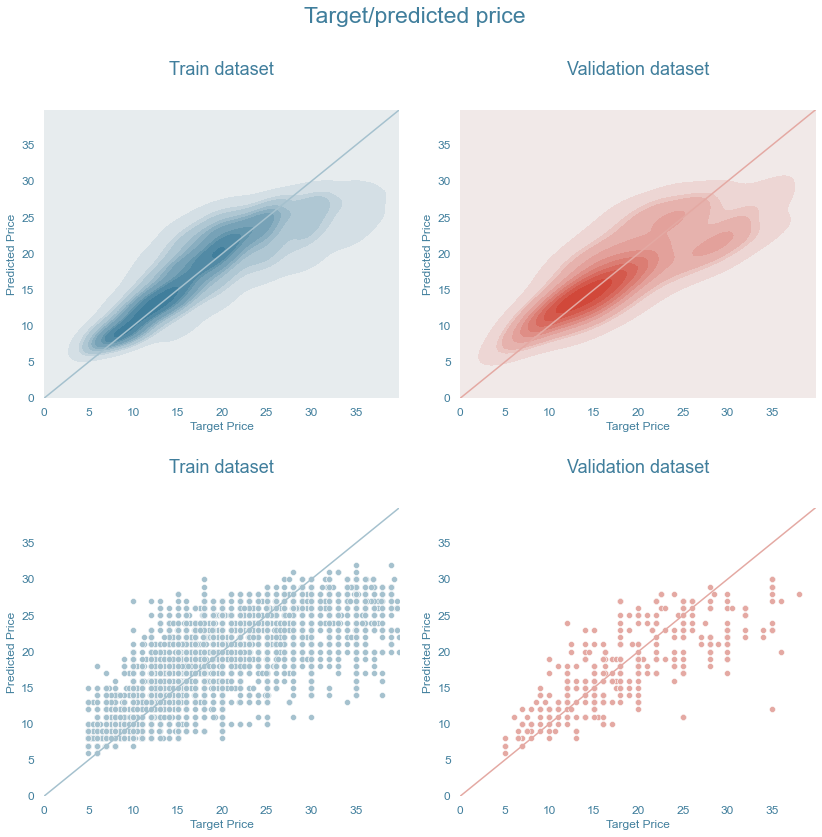

In [124]:
print()

kde_scatter_target_pred(y_train = y_train, preds_train=preds_train, y_test = y_val, 
            preds_test = preds_val, train_title = 'Train dataset', test_title = 'Validation dataset')

plt.show()

In [125]:
#Function to extract data from datasets by indices, that we will use for plotting

def random_y(y, indices):
    return list(map(y.__getitem__, indices))

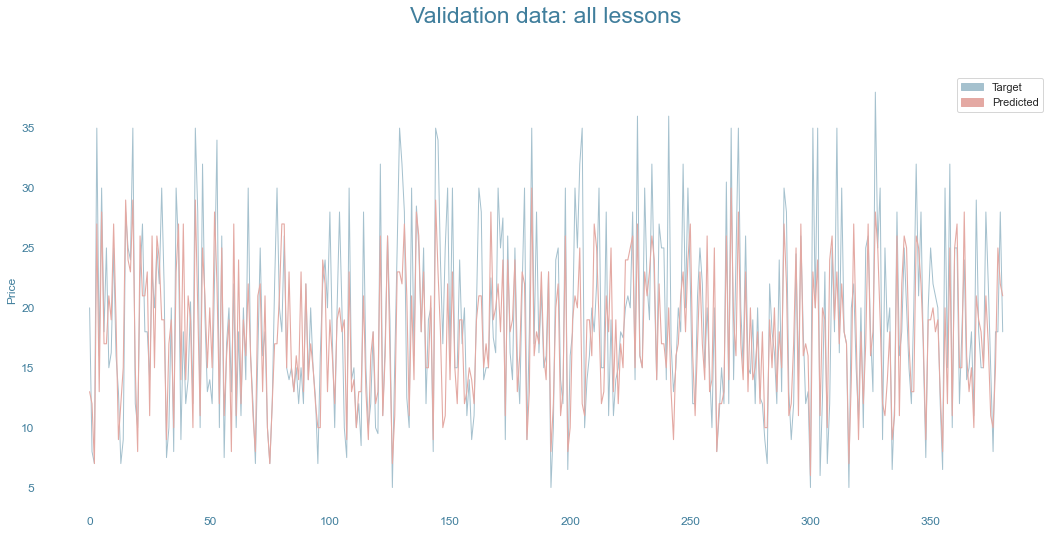

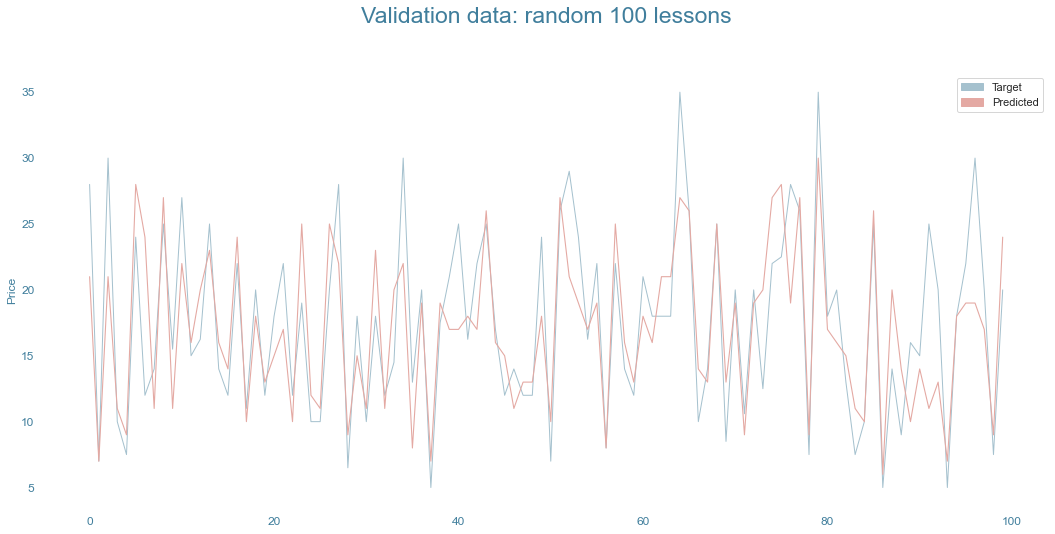

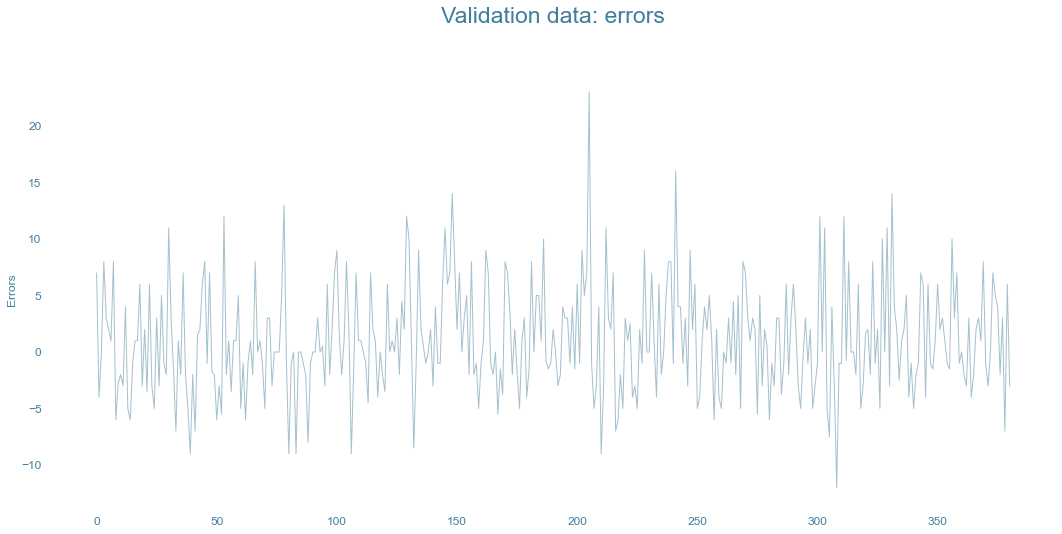

In [126]:
print()

idx_val = np.random.choice(len(y_val), replace=False, size=100)

true_pred_list = [(y_val, preds_val, "Validation data: all lessons", 'Price'),           
     (random_y(y_val, idx_val), random_y(preds_val, idx_val), "Validation data: random 100 lessons", 'Price'),
     (y_val - preds_val, [], "Validation data: errors", 'Errors', False)]

for true_pred_params in true_pred_list:
    true_pred_plot(*true_pred_params)

plt.show()

# 9. Test data predictions

In [127]:
#We will use the combined train and validation data as the train data.

data_all_train = data.append(data_val, ignore_index=True)
data_all_train = shuffle(data_all_train, random_state=RANDOM_STATE)
data_all_train.index = range(data_all_train.shape[0])

In [128]:
#Let's prepare the test data and separate the most expensive lessons in the test dataset.
data_test = all_data_prep(data_test)

data_top_5= data_top_5.append(data_test[data_test.price >= q], ignore_index=True)

data_test = data_test[data_test.price < q]
data_test.index = range(data_test.shape[0])

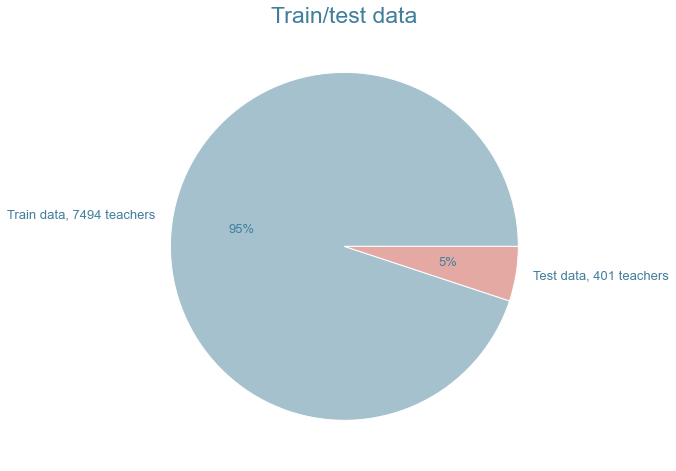

In [129]:
#Let's check if the proportion is still 95% train data / 5% test data
x = [data_all_train.shape[0], data_test.shape[0]]
labels = ['Train data', 'Test data']
labels = [f'{labels[i]}, {x[i]} teachers' for i in range(len(labels))]

print()
pie_plot(x, labels, 'Train/test data')
plt.show()

In [130]:
print(f'Train data shape {data_all_train.shape} with mean lesson price {data_all_train.price.mean()}')
print(f'Test data shape {data_test.shape} with mean lesson price {data_test.price.mean()}')

Train data shape (7494, 350) with mean lesson price 18.868917800907397
Test data shape (401, 235) with mean lesson price 19.25139650872818


In [131]:
#Add train/test mean prices to final report
report['Mean lesson price in all train data'] = data_all_train.price.mean()
report['Mean lesson price in test data'] = data_test.price.mean()

In [132]:
#Text data predictions
for col in text_columns_new:
    text_preds(data_all_train, data_test, data_all_train.price, data_test.price, col)

Lesson_Text_Info mean absolute error train 5.741307001187472
Lesson_Text_Info mean absolute error test 6.004378144495357
---
Lesson_Text_Info mean absolute error train 5.7878293161588585
Lesson_Text_Info mean absolute error test 6.041192998517189
---
Lesson_Text_Info mean absolute error train 5.242392505059648
Lesson_Text_Info mean absolute error test 5.757065343965305
---
Lesson_Text_Info mean absolute error train 5.242518317416093
Lesson_Text_Info mean absolute error test 5.757272992103281
---
----------------------------------------

Combined Lesson_Text_Info mean absolute error for train data 5.481257985184113
Combined Lesson_Text_Info mean absolute error for test data 5.854616049337679
----------------------------------------

Teacher_Text_Info mean absolute error train 5.281941012989684
Teacher_Text_Info mean absolute error test 5.561348128058107
---
Teacher_Text_Info mean absolute error train 5.379615309790882
Teacher_Text_Info mean absolute error test 5.6524848117848325
---
Tea

In [133]:
#Let's make the final predictions
X_train, X_test, y_train, y_test = all_data_conacat(data_all_train, data_test)
preds_train, preds_test = final_preds(X_train, X_test, y_train, y_test)

train_all_mae = mean_absolute_error(y_train, preds_train)
test_mae = mean_absolute_error(y_test, preds_test)

#Add these errors to final report
report['Mean absolute error (all train data)'] = mean_absolute_error(y_train, preds_train)
report['Mean absolute error (test data)'] = mean_absolute_error(y_test, preds_test)

print(f'Mean absolute error (all train data): {train_all_mae}')
print(f'Mean absolute error (test data): {test_mae}')

Mean absolute error (all train data): 3.4715492393915133
Mean absolute error (test data): 3.6105486284289277


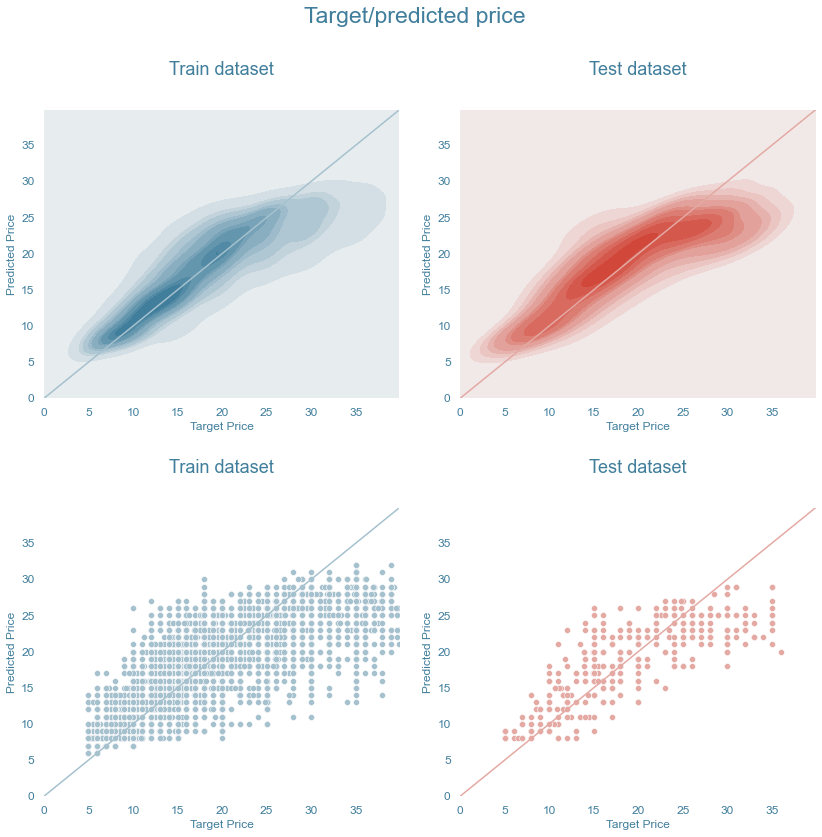

In [134]:
print()

kde_scatter_target_pred(y_train = y_train, preds_train = preds_train, y_test = y_test, 
            preds_test = preds_test, train_title = 'Train dataset', test_title = 'Test dataset')

plt.show()

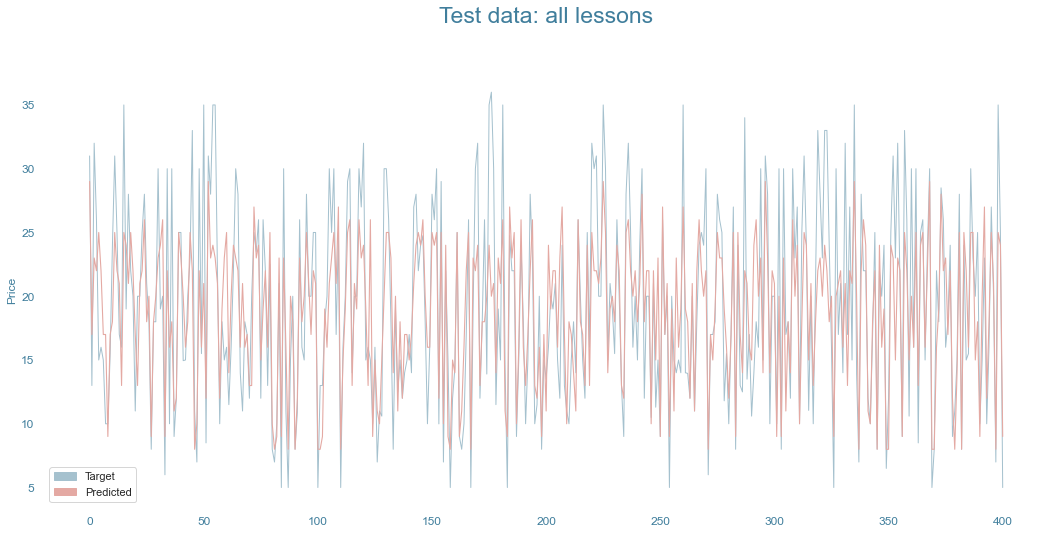

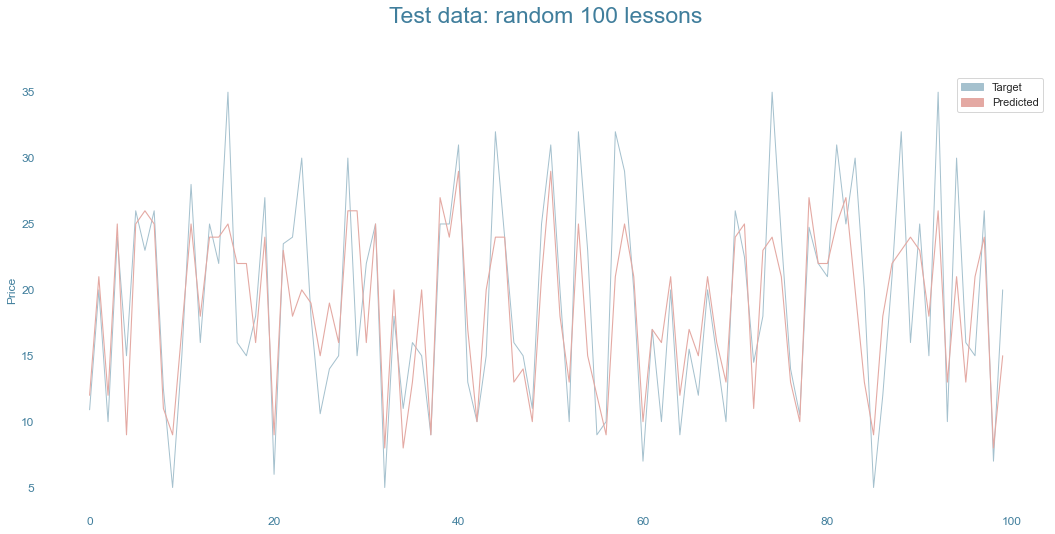

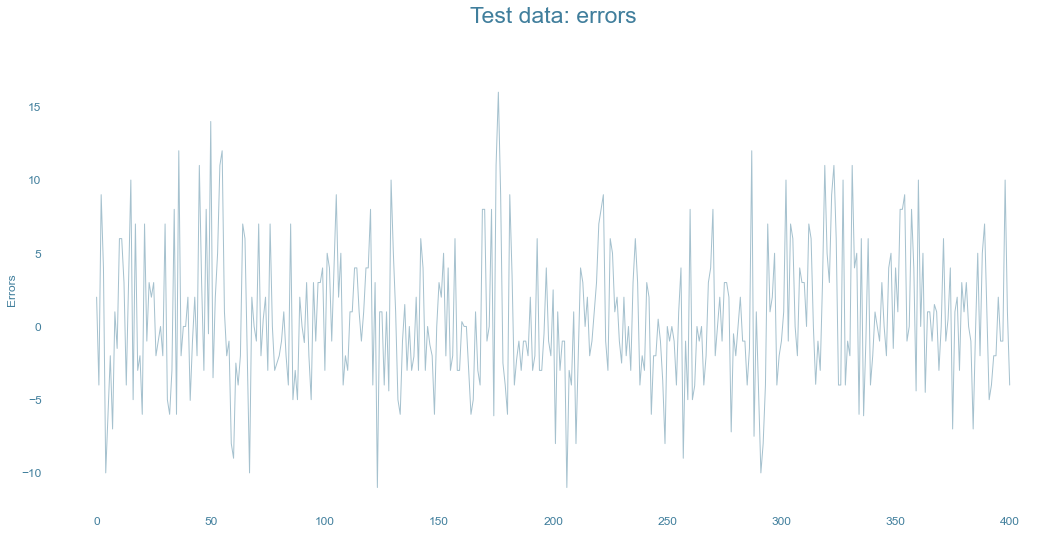

In [135]:
print()

idx_test = np.random.choice(len(y_test), replace=False, size=100)

true_pred_list = [(y_test, preds_test, "Test data: all lessons", 'Price'),
     (random_y(y_test, idx_test), random_y(preds_test, idx_test), "Test data: random 100 lessons", 'Price'),
     (y_test - preds_test, [], "Test data: errors", 'Errors', False)]

for true_pred_params in true_pred_list:
    true_pred_plot(*true_pred_params)

plt.show()

# 10. Conclusions

In [139]:
print('Project results:')
print()
i = 0
for k,v in report.items():
    i+=1
    print(f'{k: <40} USD {round(v,2)}')
    if not i%4:
        print('-----------')
    elif not i%2:
        print('')

Project results:

Mean lesson price in train data          USD 18.87
Mean lesson price in validation data     USD 18.85

Mean absolute error (train data)         USD 3.47
Mean absolute error (validation data)    USD 3.73
-----------
Mean lesson price in all train data      USD 18.87
Mean lesson price in test data           USD 19.25

Mean absolute error (all train data)     USD 3.47
Mean absolute error (test data)          USD 3.61
-----------


Possible ways of the project improvement:
    
    1. Add more teacher data. Since there are over 7,000 English teachers in italki database and only 2,776 teachers in my model, adding more teacher data would improve results.
    
    2. Go beyond English language offerings. There are 150+ possible languages on italki, but this project utilised only one.
    
    3. Capture more information about teachers and their lessons. For example, we may add reviews, photos and other important information for analysis.